In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# update cpi if flagged out of date
# cpi.update()

In [2]:
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='winter_r')

In [3]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query function
def fetcha(q):
    return cur.execute(q).fetchall()

In [4]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [5]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [6]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

# Rotten Tomatoes DF

In [7]:
# creating initial dataframe by joining the numbers and rotten tomatoes tables 
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]   

In [8]:
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [9]:
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


In [10]:
# changing name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')
dfr['directors'] = dfr['directors'].fillna('NaN')
dfr['authors'] = dfr['authors'].fillna('NaN')
dfr['production_company'] = dfr['production_company'].fillna('NaN')

In [11]:
# change date string to datetime object 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

In [12]:
#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [13]:
# adding intl gross column
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])

In [14]:
# adding net profit columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

In [15]:
# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])

In [16]:
dfr#adding adjust gross profit and budget columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

In [17]:
#adding net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

In [18]:
#checking results
dfr.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,domestic_roi,worldwide_roi,international_roi,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,-0.065597,1.347904,0.413501,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07


In [19]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net'],
      dtype='object')

In [20]:
# renaming columns
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net'],
      dtype='object')

In [21]:
# creating rt genre list
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))

In [22]:
# creating function to count genres
def genre_count(DF, genre_list):
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append(count)
    return (genre_list, counts)

# IMDB DF

In [23]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]   

In [24]:
# checking columns
dfi.columns

Index(['idx', 'nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles', 'idx', 'tconst', 'ordering',
       'category', 'job', 'characters', 'idx', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres', 'idx',
       'id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [25]:
# checking dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [26]:
# dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy","Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [27]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [28]:
# changings NaNs to strings
dfi['genres'] = dfi.genres.fillna('NaN')

In [29]:
#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [30]:
# change date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

In [31]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

In [32]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [33]:
#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

In [34]:
#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

In [35]:
#adding return on investment columns and checking results
dfi['dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,dom_roi,ww_roi,i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [36]:
# getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

In [37]:
# creating imdb top adj goss list dataframes
title_adj_gross_i = dfi[['title', 'adj_ww_gross', 'date']]
unique_titles = title_adj_gross_i.drop_duplicates(subset = ['title'])
top20_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top100_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films_i.head(1)

,title,adj_ww_gross,date
6985,Bambi,4.203440e+09,1942-08-13


In [38]:
# creating imdb top adj net list dataframes
title_net_i = dfi[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net_i.drop_duplicates(subset = ['title'])
top20_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top100_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_adj_net_films_i.head(1)

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,date
6985,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942-08-13


In [39]:
# creating imdb top adj roi list dataframes
title_roi_i = dfi[['title','adj_prod_budg',  'adj_ww_net', 'ww_roi', 'date']]
unique_titles = title_roi_i.drop_duplicates(subset = ['title'])
top20_roi_films_i = unique_titles.sort_values(by='ww_roi', ascending=False).head(20)
top100_roi_films_i = unique_titles.sort_values(by='ww_roi', ascending=False).head(100)
top20_roi_films_i.head(1)

,title,adj_prod_budg,adj_ww_net,ww_roi,date
1230,The Gallows,107864.414789,4.482465e+07,415.56474,2015-07-10


In [40]:
# creating imdb genres list
split_list = []
for genre in dfi.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
genres_i = list(set(split_list))

# Top 100 Films by Worldwide Gross

In [41]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'worldwide_gross',\
                   'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top20_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(20)

In [42]:
#  getting count by year
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})

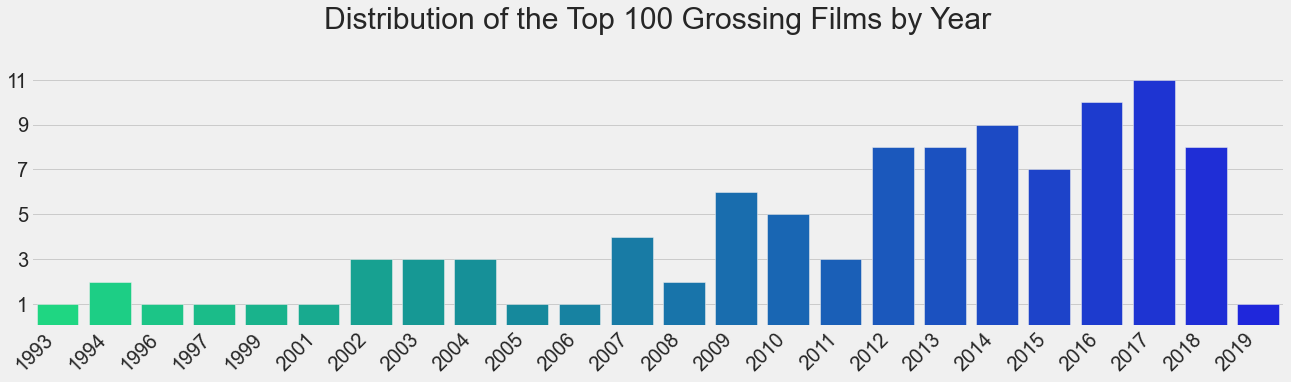

In [43]:
fig, ax= plt.subplots(figsize=(20,5))
ax = sns.barplot(x='year', y= 'count', data=t100_count_by_year, palette='winter_r')
# adjusting xticks
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 13), yticks=[1, 3, 5, 7, 9, 11])
ax.tick_params(labelsize=20) 
# label for x-axis 
ax.set_xlabel("", size = 20)
# label for y-axis 
ax.set_ylabel("") 
# title for plot 
ax.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 30 )
# render
plt.show()

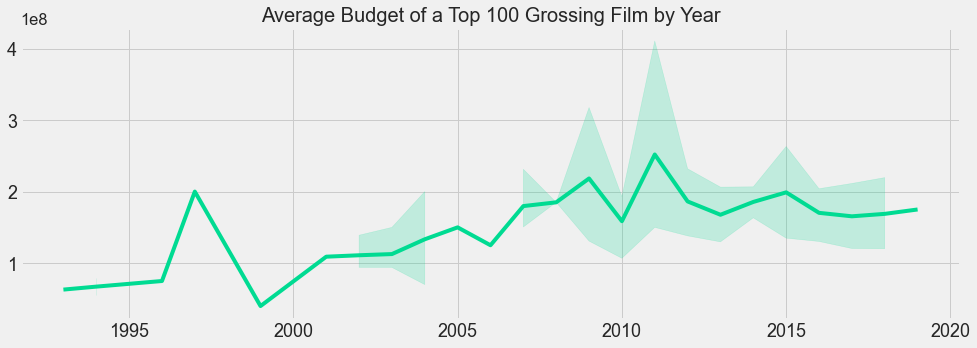

In [176]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x='year', y='production_budget', data=top100_gross_films)
# adjusting xticks
ax.tick_params(labelsize=18) 
# label for x-axis 
ax.set_xlabel("")
# removing label for y-axis 
ax.set_ylabel("") 
# title for plot 
ax.set_title( "Average Budget of a Top 100 Grossing Film by Year", size=20)
plt.show()

|Budget Stat       |Dollar Amount      |
|:-----------------|------------------:|
|Mean Budget       |       168,575,000 |
|Median Budget     |       172,500,000 |
|Min Budget        |        35,000,000 |
|Max Budget        |        425,000,000|

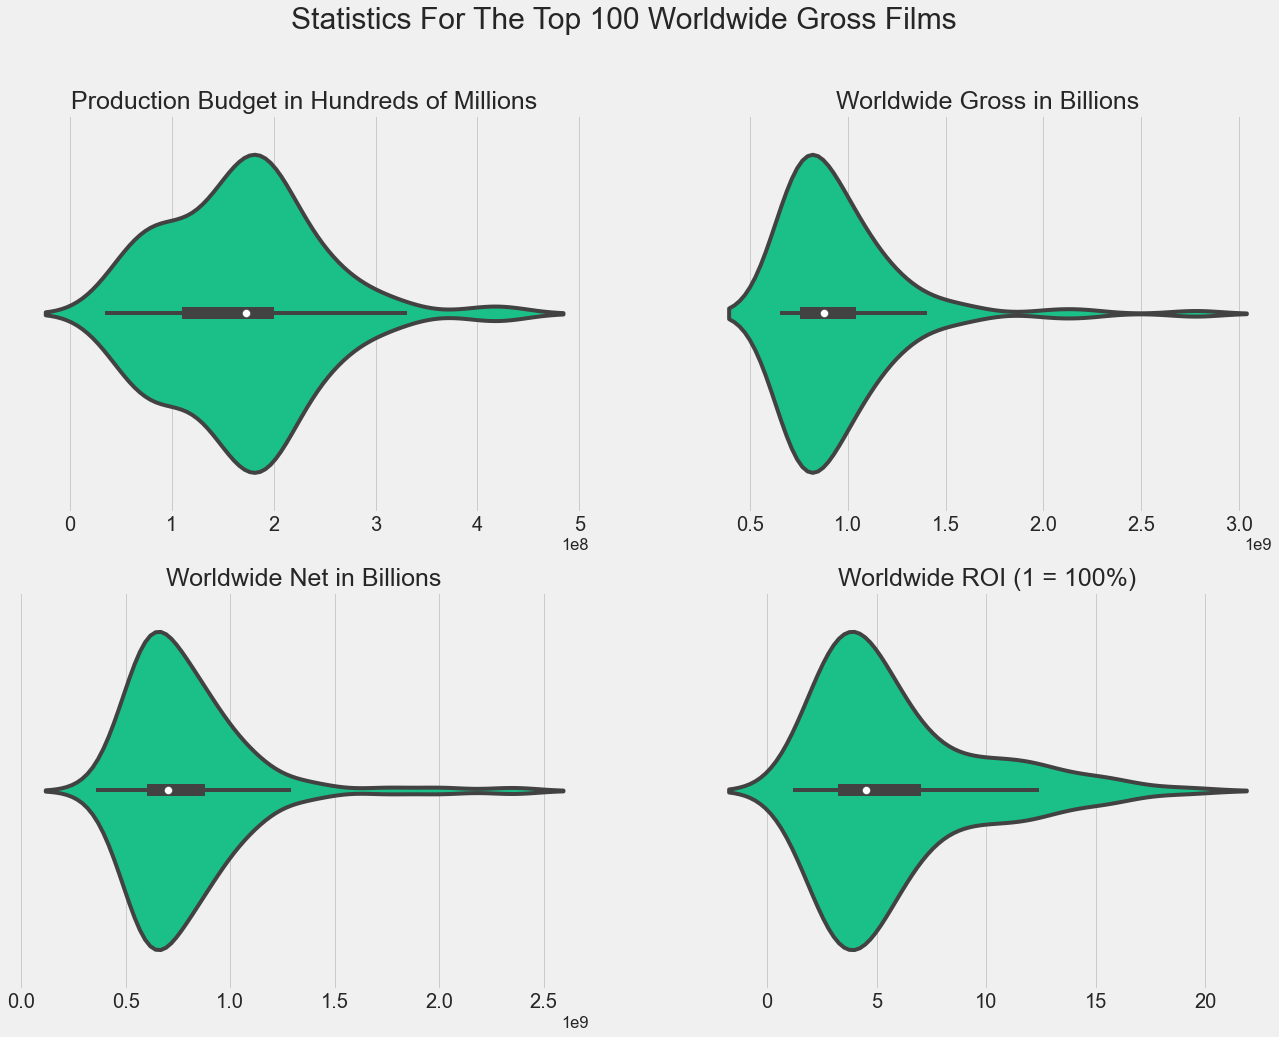

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Worldwide Gross Films', size=30)
sns.violinplot(ax=axes[0, 0], x='production_budget', data=top100_gross_films,)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=top100_gross_films)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=top100_gross_films)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=top100_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

In [46]:
# top 100 by gross basic stats
top100_gross_films.describe()

,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


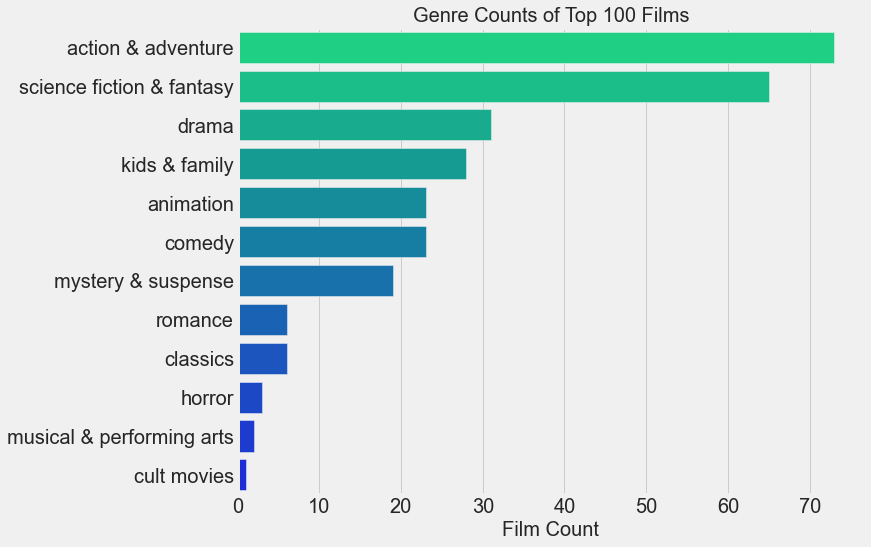

In [175]:
# top gross genres; there are overlaps because a film can have multiple genres
gross_genres = genre_count(top100_gross_films, genres)
top_g_genres = pd.DataFrame()
top_g_genres['Genre'] = gross_genres[0]
top_g_genres['Count'] = gross_genres[1]
top_g_genres = top_g_genres.sort_values(by='Count', ascending=False).head(12)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_g_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20)
ax.set_ylabel("")
ax.set_title("Genre Counts of Top 100 Films", fontsize=20)
plt.show()

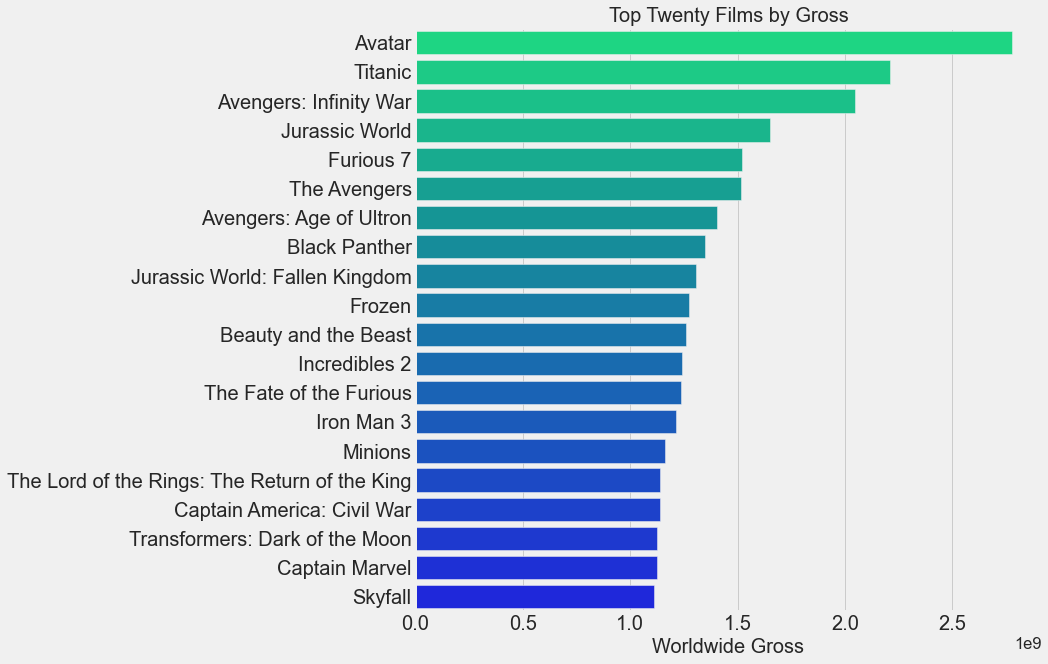

In [48]:
# plotting top 20 films by gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_gross', y='title', data= top20_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Gross', size = 20)
plt.show()

In [49]:
top20_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False).head(20)

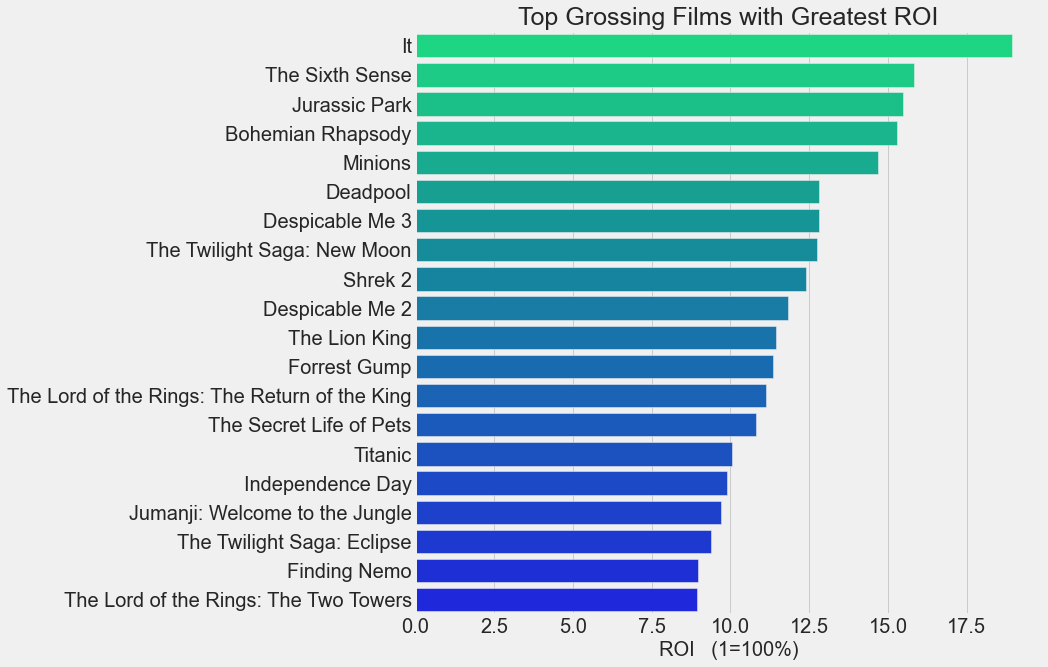

In [50]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data=top20_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("ROI   (1=100%)", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Grossing Films with Greatest ROI', size = 25)
plt.show()

# Top 100 Films by Adjusted Gross

In [51]:
# creating dataframes sorted by adjusted gross
title_adj_gross = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                       'adj_ww_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)

In [52]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


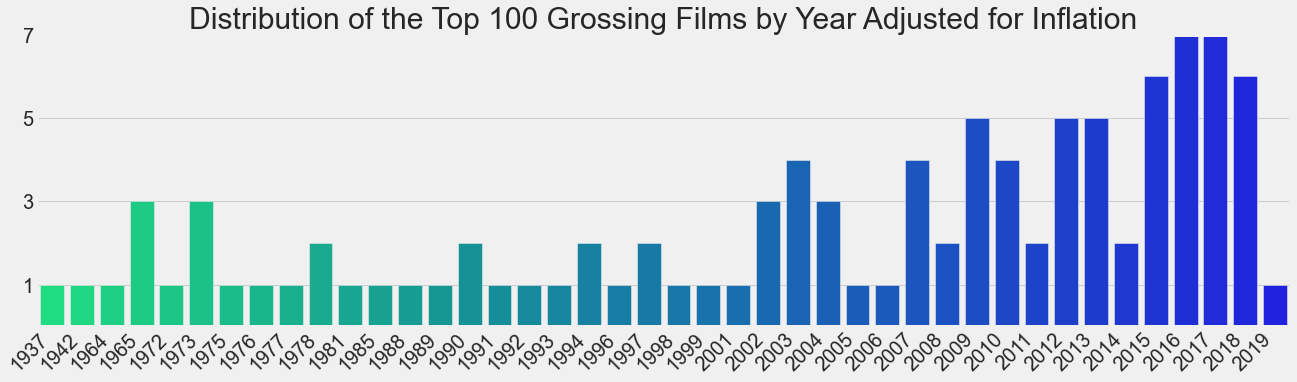

In [53]:
fig, ax= plt.subplots(figsize=(20,5))
ax = sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, palette='winter_r')
# adjusting ticks
plt.xticks(rotation=45, ha='right')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 7), yticks=[1, 3, 5, 7])
# label for x-axis 
ax.set_xlabel("", size = 20)
# label for y-axis 
ax.set_ylabel("") 
# title for plot 
ax.set_title("Distribution of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 30)
# render
plt.show()

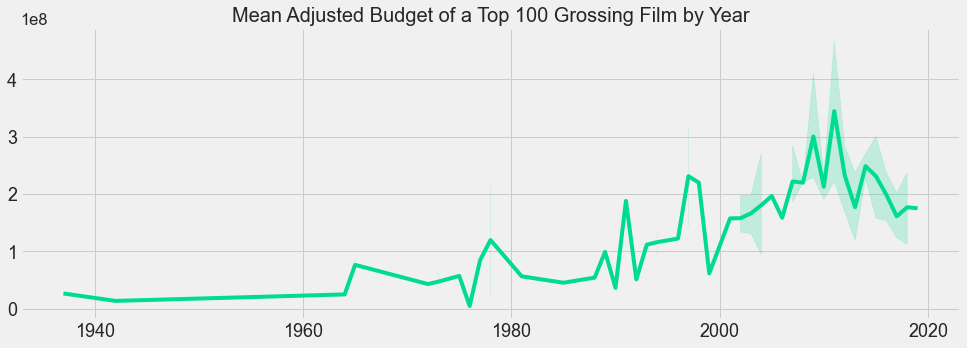

In [177]:
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films)
# adjusting xticks
ax.tick_params(labelsize=18)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
# label for x-axis 
ax.set_xlabel("") 
# label for y-axis 
ax.set_ylabel("") 
# title for plot 
ax.set_title( "Mean Adjusted Budget of a Top 100 Grossing Film by Year", size=20) 
plt.show()

|Budget Stat       |Dollar Amount      |
|:-----------------|------------------:|
|Mean Budget       |        168,748,084|
|Median Budget     |        179,232,282|
|Min Budget        |          4,493,093|
|Max Budget        |        506,459,142|

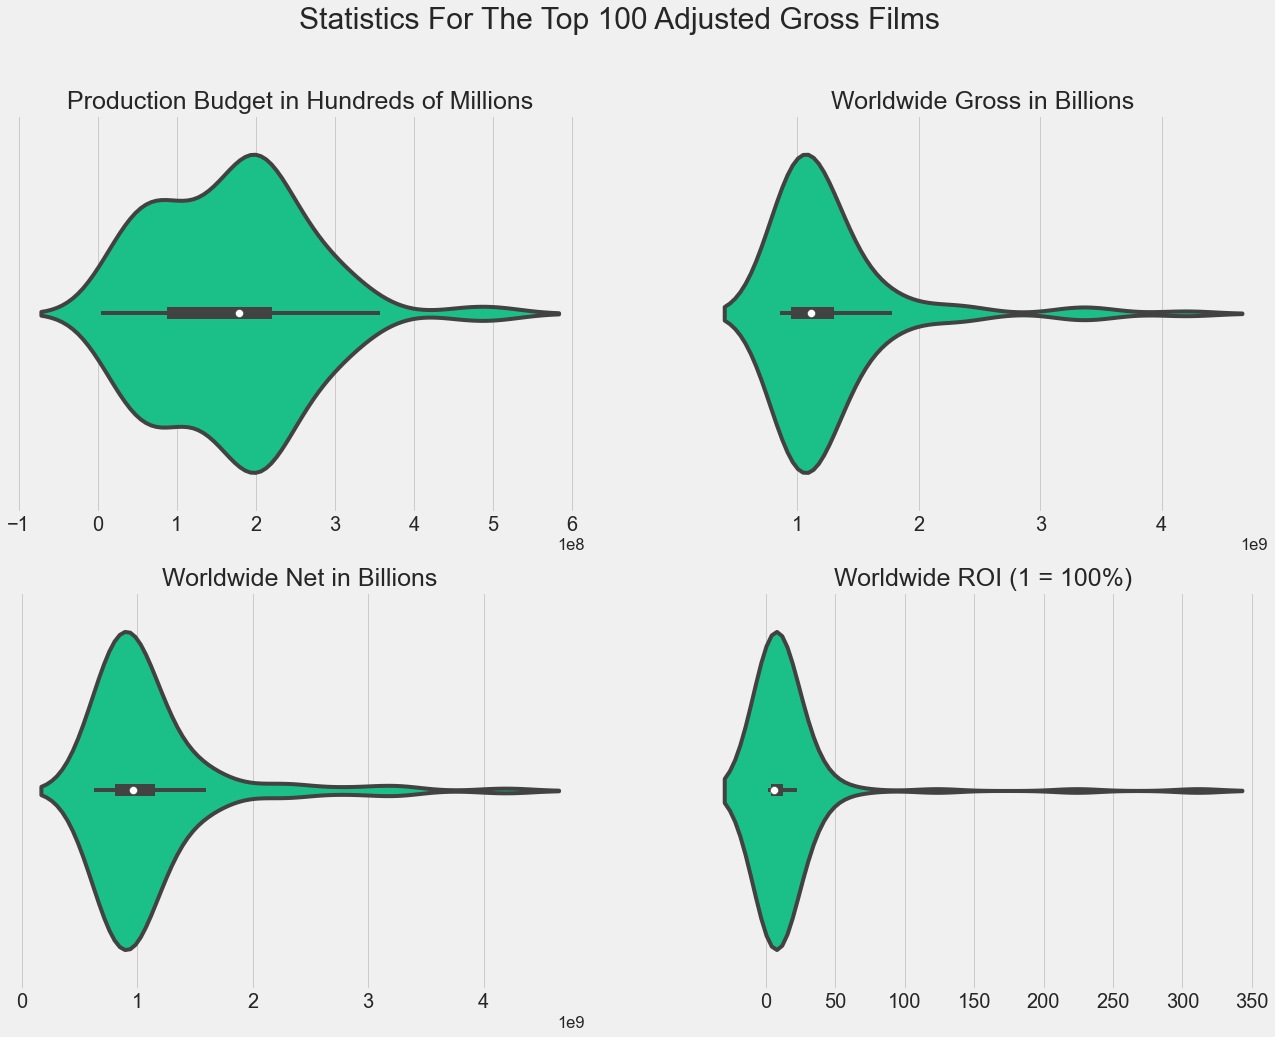

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Adjusted Gross Films', size=30)
sns.violinplot(ax=axes[0, 0], x='adj_prod_budg', data=top100_adj_gross_films)
sns.violinplot(ax=axes[0, 1], x='adj_ww_gross', data=top100_adj_gross_films)
sns.violinplot(ax=axes[1, 0], x='adj_ww_net', data=top100_adj_gross_films)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=top100_adj_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

In [56]:
# top 100 by adjusted gross basic stats
print(f'mean {top100_adj_gross_films.adj_prod_budg.mean()}')
print(f'median {top100_adj_gross_films.adj_prod_budg.median()}')
print(f'min {top100_adj_gross_films.adj_prod_budg.min()}')
print(f'max {top100_adj_gross_films.adj_prod_budg.max()}')
top100_adj_gross_films.describe()

mean 168748084.47432208
median 179232282.51574492
min 4493093.145869947
max 506459142.2458597


,adj_prod_budg,adj_ww_gross,adj_ww_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


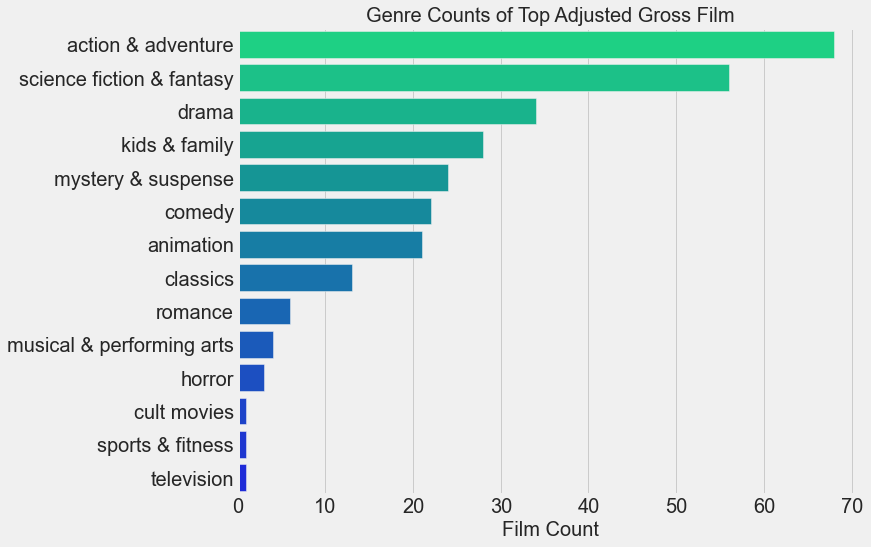

In [57]:
# top adjusted gross genres; there are overlaps because a film can have multiple genres
adj_genres = genre_count(top100_adj_gross_films, genres)
top_a_genres = pd.DataFrame()
top_a_genres['Genre'] = adj_genres[0]
top_a_genres['Count'] = adj_genres[1]
top_a_genres = top_a_genres.sort_values(by='Count', ascending=False).head(14)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_a_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20)
ax.set_ylabel("")
ax.set_title("Genre Counts of Top Adjusted Gross Film", fontsize=20)
plt.show()

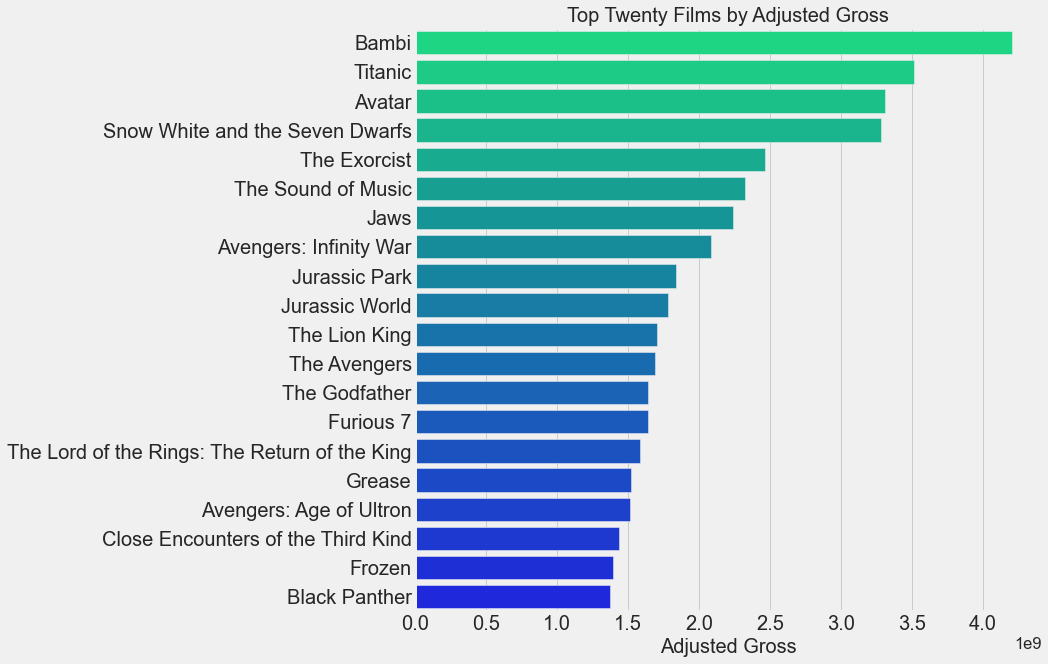

In [58]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_gross', y='title', data= top20_adj_gross_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Gross", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Adjusted Gross', size = 20)
plt.show()

In [59]:
top20_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='worldwide_roi', ascending=False).head(20)
# t100_adj_gross_by_roi.head(1)

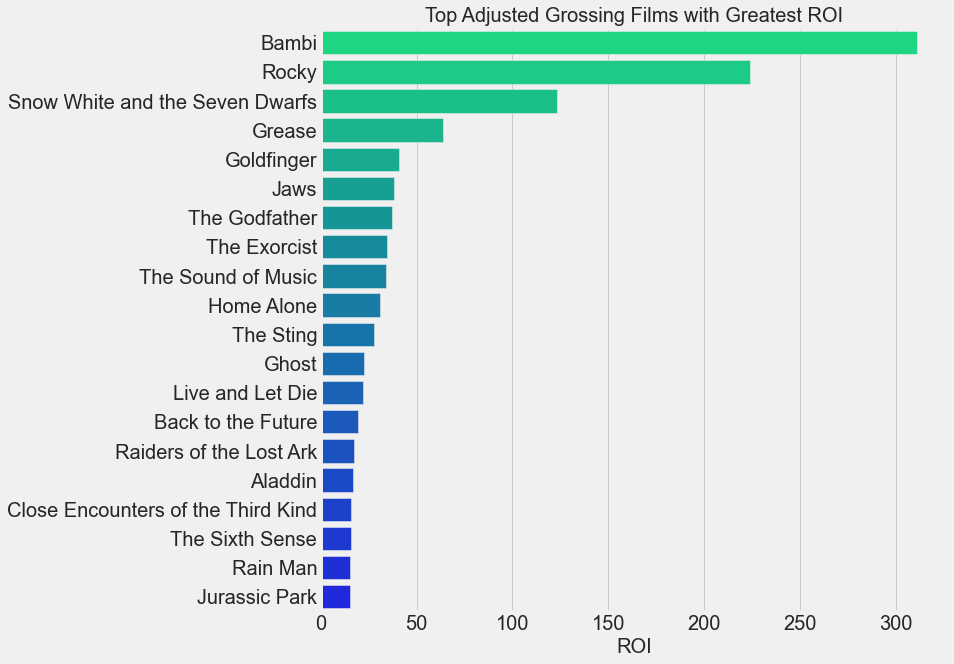

In [60]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data= top20_adj_gross_by_roi, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("ROI", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Adjusted Grossing Films with Greatest ROI', size = 20)
plt.show()

# Top ROI Genres & Films

In [61]:
title_roi = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_titles = title_roi.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='worldwide_roi', ascending=False).head(100)

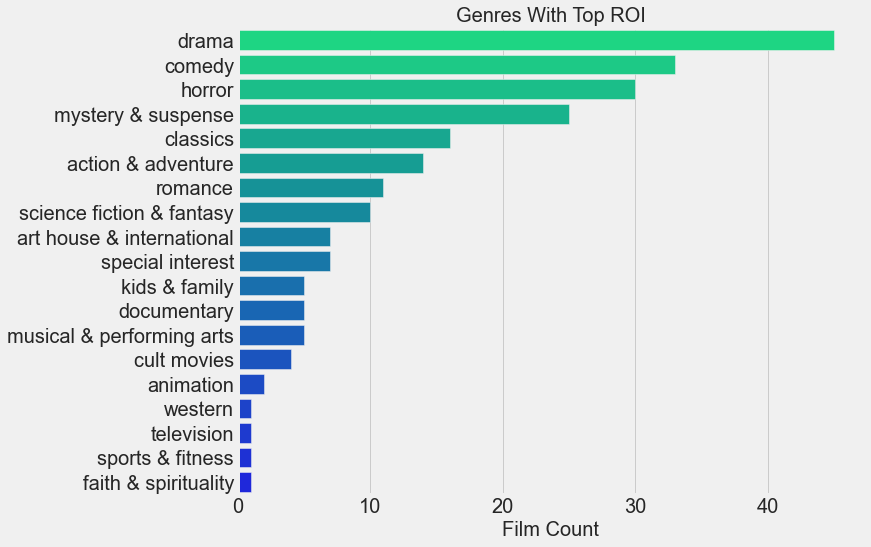

In [62]:
# top ROI genres; there are overlaps because a film can have multiple genres
roi_genres = genre_count(top100_roi_films, genres)
top_r_genres = pd.DataFrame()
top_r_genres['Genre'] = roi_genres[0]
top_r_genres['Count'] = roi_genres[1]
top_r_genres = top_r_genres.sort_values(by='Count', ascending=False).head(19)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_r_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top ROI", fontsize=20)
plt.show()

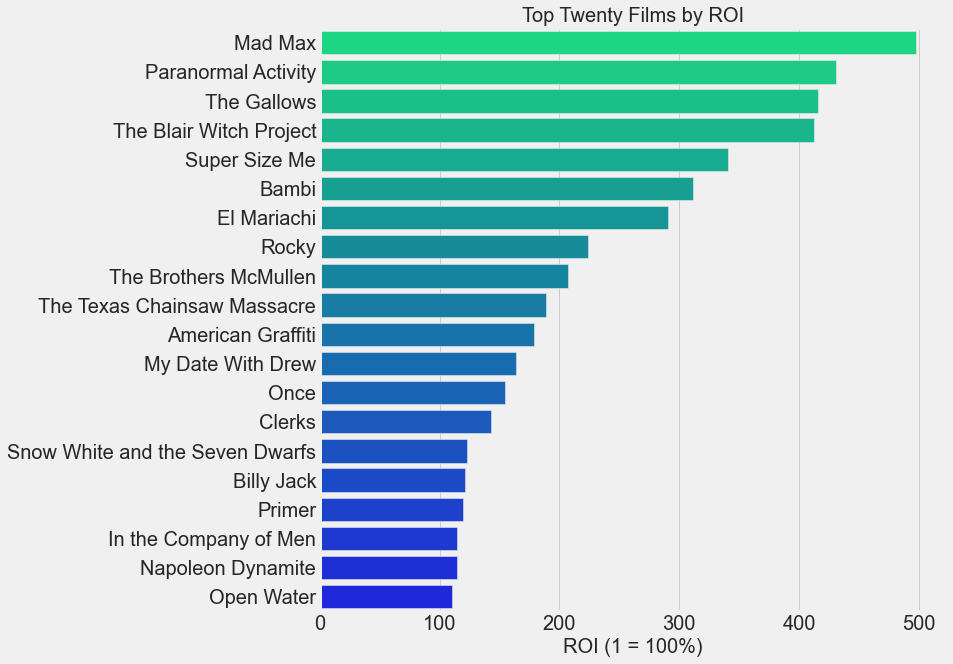

In [63]:
# plotting top 20 films by ROI
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_roi', y='title', data= top20_roi_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("ROI (1 = 100%)", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by ROI', size = 20)
plt.show()

# Top Creative Talent

# Top 20 Actors By Worldwide Gross

In [64]:
#  dropping problematic titles
dfi = dfi[dfi.title != 'Titanic']
dfi = dfi[dfi.title != 'Cinderella']
dfi = dfi[dfi.title != 'Snow White and the Seven Dwarfs']
dfi = dfi[dfi.title != 'Beauty and the Beast']
dfi = dfi[dfi.title != 'Bambi']
dfi = dfi[dfi.title != 'Avatar']
dfi = dfi[dfi.title != 'Pinocchio']
dfi = dfi[dfi.title != 'Ben-Hur']

In [65]:
dfi.columns

Index(['nconst', 'primary_name', 'tconst', 'category', 'genres', 'date',
       'title', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'adj_prod_budg',
       'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross', 'adj_dom_net',
       'adj_ww_net', 'adj_i_net', 'dom_roi', 'ww_roi', 'i_roi'],
      dtype='object')

In [66]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

In [67]:
# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name'])\
                                          .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)
top100_actors.head(1)

,worldwide_gross
primary_name,
Robert Downey Jr.,9.697976e+09


In [68]:
# resetting index
reset_idx = top100_actors.reset_index()

In [69]:
# getting name list
actor_list = list(reset_idx.primary_name)

In [70]:
# running imdb actor list against rt movie list to work-around problematic titles.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross.append(value)
gross[:1]

[10240685850.0]

In [71]:
#  creating new adj gross dataframe
dict = {'primary_name': actor_list, 'worldwide_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_gross_actors = gross_df.sort_values(by='worldwide_gross', ascending=False).head(50)
top50_gross_actors.head(1)

,primary_name,worldwide_gross
Samuel L. Jackson,Samuel L. Jackson,1.597905e+10


In [72]:
# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)
count_m.head(1)

,title
primary_name,
50 Cent,2


In [73]:
# joining dfs
joined_m = top50_gross_actors.join(count_m)
joined_m.head(1)

,primary_name,worldwide_gross,title
Samuel L. Jackson,Samuel L. Jackson,1.597905e+10,12


In [74]:
# adding mean gross column
joined_m['mean_gross'] = joined_m.worldwide_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [75]:
# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)

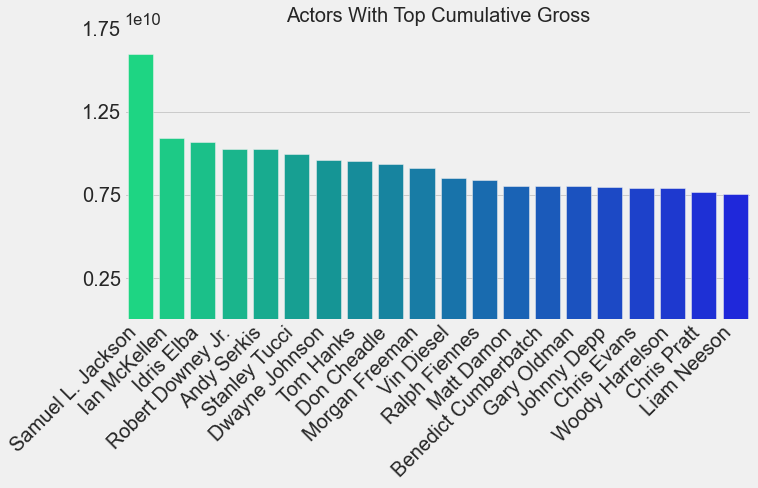

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .75*10**10, 1.25*10**10, 1.75*10**10])
plt.xticks(rotation=45, ha='right')
ax.set_xlabel("")
# ax.set_xlabel("Actor", fontsize=20)
ax.set_ylabel("")
# ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20)
ax.set_title("Actors With Top Cumulative Gross", fontsize=20)
plt.show()

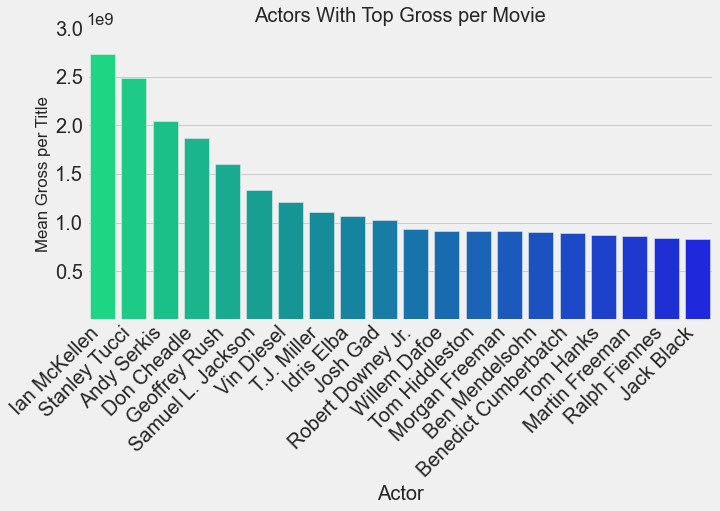

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("Actor", fontsize=20 ) 
# ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actors With Top Gross per Movie", fontsize=20) 
plt.show() 

## Top 20 Actresses By Adjusted Gross

In [78]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

In [79]:
# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name'])\
                                               .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)
top100_actresses.head(1)

,worldwide_gross
primary_name,
Jennifer Lawrence,5.113642e+09


In [80]:
# resetting index
reset_idx_f = top100_actresses.reset_index()

In [81]:
# getting name list and adding kate winslet
actress_list = list(reset_idx_f.primary_name)[:99]
actress_list.append('Kate Winslet')

In [82]:
# running imdb actress list against rt movie list to work-around problematic titles.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].worldwide_gross.sum()
    gross_f.append(value)
gross_f[:1]

[5910248798.0]

In [83]:
#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'worldwide_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_gross_actresses = gross_df_f.sort_values(by='worldwide_gross', ascending=False).head(50)
top50_gross_actresses.head(1)

,primary_name,worldwide_gross
Cate Blanchett,Cate Blanchett,1.164715e+10


In [84]:
# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()
count_f = pd.DataFrame(movie_count_f)
count_f.head(1)

,title
primary_name,
AJ Michalka,2


In [85]:
# joining dfs
joined_f = top50_gross_actresses.join(count_f)
joined_f.head(1)

,primary_name,worldwide_gross,title
Cate Blanchett,Cate Blanchett,1.164715e+10,10


In [86]:
# added mean gross column
joined_f['mean_gross'] = joined_f.worldwide_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [87]:
# sorting top 20s
top20_cuml_gross_actresses = joined_f.sort_values\
                            (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values\
                            (by='Mean Gross per Title', ascending=False).head(20)

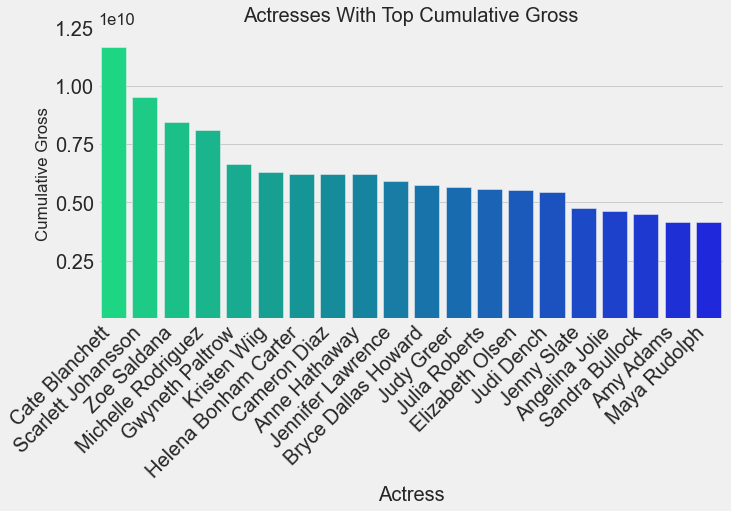

In [88]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10])
ax.set_xlabel("Actress", fontsize=20 )
# ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Actresses With Top Cumulative Gross", fontsize=20)
plt.show()

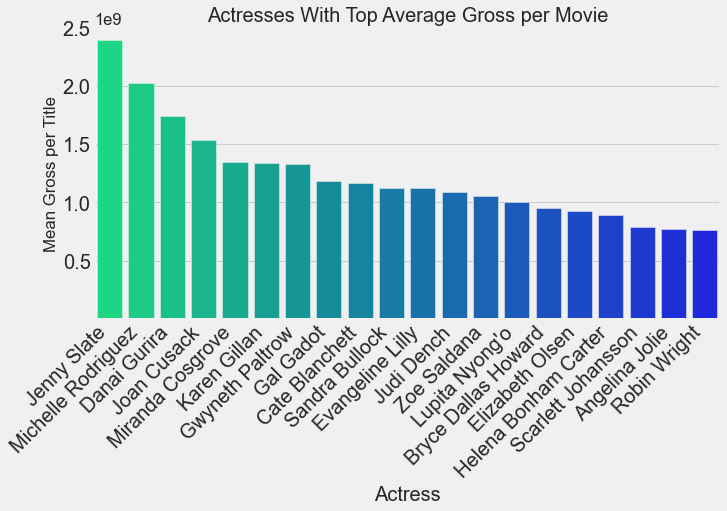

In [89]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title',\
            data=top20_mean_gross_actresses, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9])
ax.set_xlabel("Actress", fontsize=20 ) 
# ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top Directors by Adjusted Gross

In [90]:
# creating director df
director_df = dfi[dfi['category'].str.contains('director')]

In [91]:
# top 100 directors
top100_adj_gross_directors = director_df.groupby(['primary_name'])\
                                                 .worldwide_gross.sum().sort_values(ascending=False).head(100)
top100_directors = pd.DataFrame(top100_adj_gross_directors)

In [92]:
# resting index
reset_idx_d = top100_directors.reset_index()

In [93]:
# getting name list adding james cameron
director_list = list(reset_idx_d.primary_name)[:99] 
director_list.append('James Cameron')

In [94]:
# running imdb director list against rt movie list to work-around problematic titles.
gross_d = []
for name in director_list:
    value = dfr[dfr['directors'].str.contains(name)].adj_ww_gross.sum()
    gross_d.append(value)
gross_d[:1]

[4243069274.258812]

In [95]:
#  creating new adj gross dataframe
dict = {'primary_name': director_list, 'adj_ww_gross': gross_d}
gross_df_d = pd.DataFrame(dict, index=director_list)
top50_adj_gross_directors = gross_df_d.sort_values(by='adj_ww_gross', ascending=False).head(50)

In [96]:
# movie count
movie_count_d = director_df.groupby(['primary_name']).title.count()
count_d = pd.DataFrame(movie_count_d)

In [97]:
# joining dfs
joined_d = top50_adj_gross_directors.join(count_d)

In [98]:
# adding mean gross column
joined_d['mean_gross'] = joined_d.adj_ww_gross/joined_d.title
joined_d = joined_d.reset_index()
joined_d = joined_d.rename(columns={'primary_name': 'Director',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [99]:
# adding values for james cameron
joined_d.loc[[2],'Number of Titles'] = dfr[dfr.directors.str.contains('James Cameron')].title.count()
joined_d.loc[[2], 'Mean Gross per Title'] = joined_d.loc[[2], 'Cumulative Gross']/joined_d.loc[[2],'Number of Titles']

In [100]:
# creating top 20 lists
top20_cuml_gross_directors = joined_d.sort_values\
                             (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_directors = joined_d.sort_values\
                             (by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_directors.head(1)

,index,Director,Cumulative Gross,Number of Titles,Mean Gross per Title
0,Steven Spielberg,Steven Spielberg,1.517290e+10,8.0,1.896612e+09


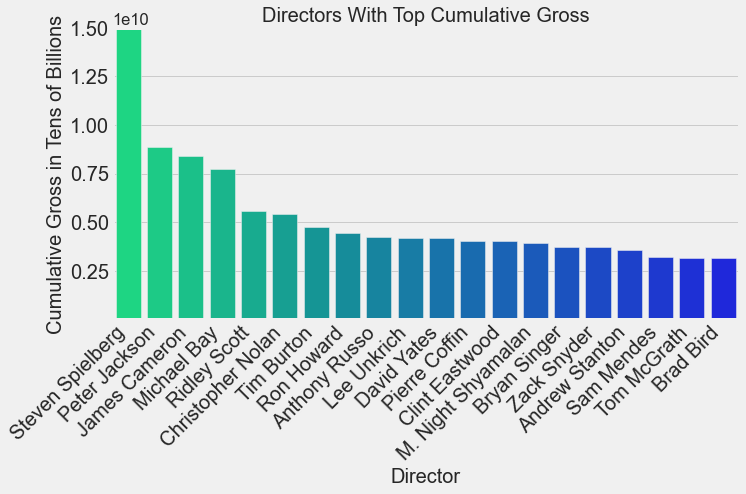

In [101]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Cumulative Gross', data=top20_cuml_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**10), yticks=[.25*10**10, .5*10**10, .75*10**10,\
                                  1.0*10**10, 1.25*10**10, 1.5*10**10])
ax.set_xlabel("Director", fontsize=20 )
ax.set_ylabel("Cumulative Gross in Tens of Billions" , fontsize=20 )
ax.set_title("Directors With Top Cumulative Gross", fontsize=20)
plt.show()

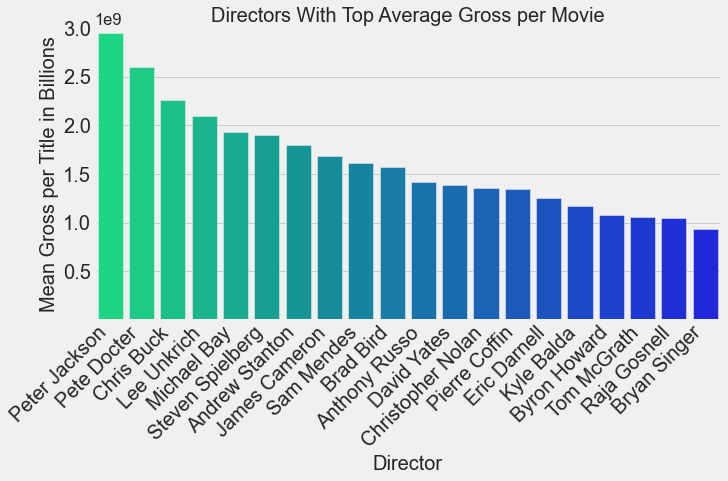

In [102]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Mean Gross per Title', data=top20_mean_gross_directors, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1.0*10**9, 1.5*10**9, 2.0*10**9, 2.5*10**9, 3.0*10**9])
ax.set_xlabel("Director", fontsize=20 ) 
ax.set_ylabel("Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Directors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top Writers by Gross

In [103]:
# creating writer df
writer_df = dfi[dfi['category'].str.contains('writer')]

In [104]:
# initial top 100
top100_gross_writers = writer_df.groupby(['primary_name'])\
                                             .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_writers = pd.DataFrame(top100_gross_writers)
top100_writers.head(1)

,worldwide_gross
primary_name,
Stan Lee,1.270937e+10


In [105]:
# resetting index
reset_idx_w = top100_writers.reset_index()

In [106]:
# getting name list
writer_list = list(reset_idx_w.primary_name)

In [107]:
# running imdb writer list against rt movie list to work-around problematic titles.
gross_w = []
for name in writer_list:
    value = dfr[dfr['authors'].str.contains(name)].worldwide_gross.sum()
    gross_w.append(value)

In [108]:
#  creating new adj gross dataframe
dict = {'primary_name': writer_list, 'worldwide_gross': gross_w}
gross_df_w = pd.DataFrame(dict, index=writer_list)
top50_gross_writers = gross_df_w.sort_values(by='worldwide_gross', ascending=False).head(50)
top50_gross_writers.head(1)

,primary_name,worldwide_gross
Fran Walsh,Fran Walsh,6.723257e+09


In [109]:
# movie count
movie_count_w = writer_df.groupby(['primary_name']).title.count()
count_w = pd.DataFrame(movie_count_w)
count_w.head(1)

,title
primary_name,
A. Jaye Williams,1


In [110]:
# joining dfs
joined_w = top50_gross_writers.join(count_w)
joined_w.head(1)

,primary_name,worldwide_gross,title
Fran Walsh,Fran Walsh,6.723257e+09,4


In [111]:
# added mean gross column
joined_w['mean_gross'] = joined_w.worldwide_gross/joined_w.title
joined_w = joined_w.reset_index()
joined_w = joined_w.rename(columns={'primary_name': 'Writer',\
                                       'title': 'Number of Titles', 'worldwide_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [112]:
# sorting top 20s
top20_cuml_gross_writers = joined_w.sort_values\
                        (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_writers = joined_w.sort_values\
                           (by='Mean Gross per Title', ascending=False).head(20)

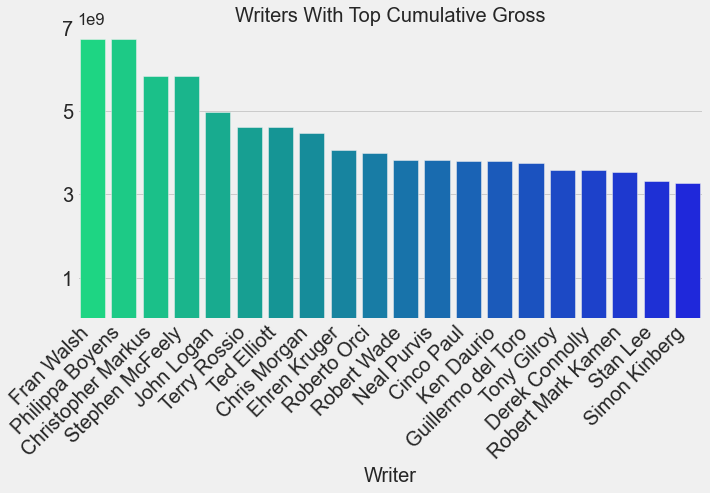

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Writer', y='Cumulative Gross', data=top20_cuml_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[1*10**9, 3*10**9, 5*10**9, 7*10**9])
ax.set_xlabel("Writer", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Writers With Top Cumulative Gross", fontsize=20)
plt.show()

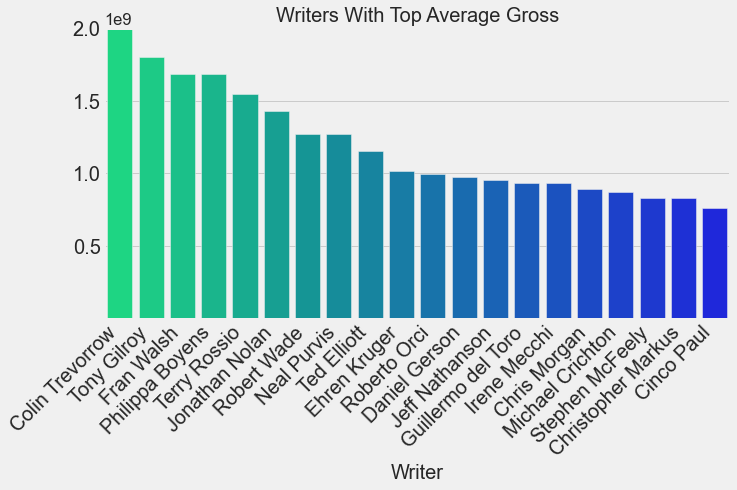

In [114]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Writer', y='Mean Gross per Title', data=top20_mean_gross_writers, palette='winter_r')
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
ax.set(ylim=(0, 1*10**9), yticks=[.5*10**9, 1*10**9, 1.5*10**9, 2*10**9])
ax.set_xlabel("Writer", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Writers With Top Average Gross", fontsize=20)
plt.show()

# Top Production Companies and Producers

## Top 20 Production Companies

In [115]:
top100_prod_companies = dfr.groupby(['production_company'])\
                                    .worldwide_gross.sum().sort_values(ascending=False).head(100) 
top100_prod_companies = pd.DataFrame(top100_prod_companies)
top20_prod_companies = top100_prod_companies.head(20)
top20_prod_companies = top20_prod_companies.reset_index()

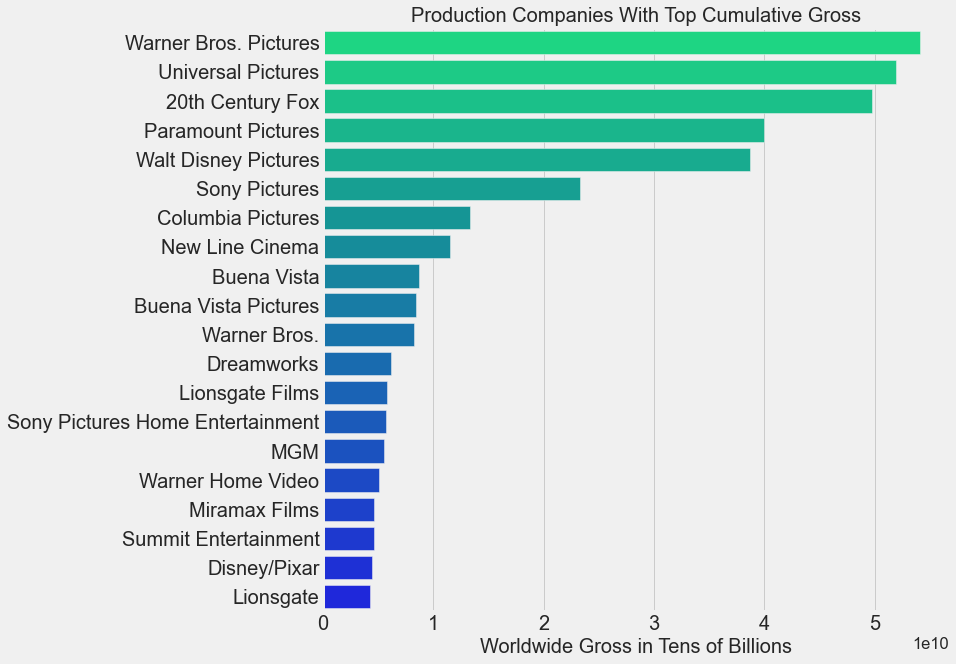

In [116]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='worldwide_gross', y='production_company', data=top20_prod_companies, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross in Tens of Billions", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Production Companies With Top Cumulative Gross", fontsize=20)
plt.show()

## Top Producers

In [117]:
# creating imdb dataframes
title_dfi_p = dfi[['title', 'primary_name', 'worldwide_gross',\
                   'adj_ww_gross', 'date', 'category', 'genres']]
producer_df = title_dfi_p[title_dfi_p['category'] == 'producer']\
                                .sort_values(by='worldwide_gross', ascending=False)

In [118]:
top100_prod = producer_df.groupby(['primary_name'])\
                                        .worldwide_gross.sum().sort_values(ascending=False).head(100)
top100_producers = pd.DataFrame(top100_prod)
top100_producers.head(1)

,worldwide_gross
primary_name,
Kevin Feige,6.487829e+09


In [119]:
# resetting index
reset_idx_p = top100_producers.reset_index()

In [120]:
# getting name list
producer_list = list(reset_idx_p.primary_name)
len(producer_list)

100

In [121]:
# producer_df = 
producers_df = pd.DataFrame(reset_idx_p)
top20_producers = producers_df.head(20)

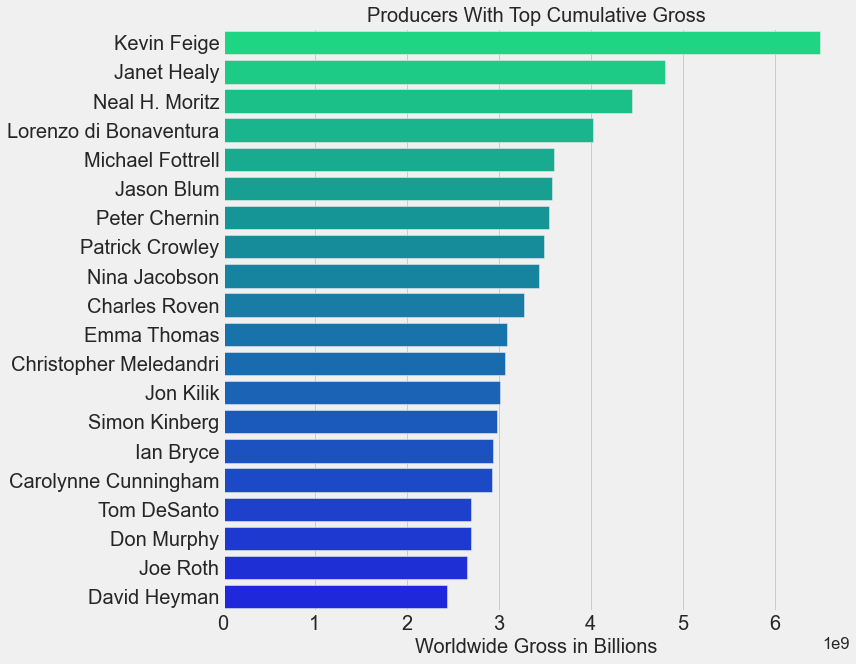

In [122]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='worldwide_gross', y='primary_name', data=top20_producers, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Worldwide Gross in Billions", fontsize=20)
ax.set_ylabel("")
ax.set_title("Producers With Top Cumulative Gross", fontsize=20)
plt.show()

## Talent Genres Prelim Work

## Actors Top Genres

In [126]:
# finding optimal genre by imdb cumulative gross for each actor in top 100
optimal_genre = []
for actor in actor_list:
    collection = []
    for genre in genres_i:
        gross = actor_df[(actor_df['primary_name'] == actor)\
                         & (actor_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((actor, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
optimal_genre[:1]

[('Robert Downey Jr.', 'adventure', 9621856386.0)]

In [127]:
# creating actor optimal genre dataframe
actor_genre = []
actor_gross = []
for i in range(100):
    actor_genre.append(optimal_genre[i][1])
    actor_gross.append(optimal_genre[i][2])
actor_genre_df = pd.DataFrame()
actor_genre_df['actor'] = actor_list
actor_genre_df['genre'] = actor_genre
actor_genre_df['worldwide_gross'] = actor_gross

In [128]:
# optimal genre for each actor
actor_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,actor,genre,worldwide_gross
0,Robert Downey Jr.,adventure,9.621856e+09


In [129]:
# genre counts for top 100 actors
actor_genre_df.genre.value_counts()

adventure    47
action       31
comedy       16
sci-fi        2
drama         2
crime         1
fantasy       1
Name: genre, dtype: int64

In [130]:
# genre counts for top 50
actor_genre_df.sort_values(by='worldwide_gross', ascending=False).head(50).genre.value_counts()

adventure    24
action       18
comedy        6
sci-fi        1
crime         1
Name: genre, dtype: int64

## Actress Top Genres

In [131]:
# finding optimal genre by adjusted gross
optimal_genre = []
for actress in actress_list:
    collection = []
    for genre in genres_i:
        gross = actress_df[(actress_df['primary_name'] == actress)\
                         & (actress_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((actress, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [132]:
# creating optimal genre dataframe
actress_genre = []
actress_gross = []
for i in range(100):
    actress_genre.append(optimal_genre[i][1])
    actress_gross.append(optimal_genre[i][2])
actress_genre_df = pd.DataFrame()
actress_genre_df['actress'] = actress_list
actress_genre_df['genre'] = actress_genre
actress_genre_df['worldwide_gross'] = actress_gross

In [133]:
# optimal genre for each
actress_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,actress,genre,worldwide_gross
0,Jennifer Lawrence,sci-fi,4.308301e+09


In [134]:
# genre counts for top 100
actress_genre_df.genre.value_counts()

adventure    40
action       19
comedy       16
drama        12
fantasy       6
music         2
romance       2
sci-fi        2
family        1
Name: genre, dtype: int64

In [135]:
# genre counts for top 50
actress_genre_df.sort_values(by='worldwide_gross', ascending=False).head(50).genre.value_counts()

adventure    20
action       11
comedy        8
drama         5
romance       2
sci-fi        2
fantasy       2
Name: genre, dtype: int64

## Director Top Genres

In [136]:
# finding optimal genre by adjusted gross
optimal_genre = []
for director in director_list:
    collection = []
    for genre in genres_i:
        gross = director_df[(director_df['primary_name'] == director)\
                         & (director_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((director, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [137]:
# creating optimal genre dataframe
director_genre = []
director_gross = []
for i in range(100):
    director_genre.append(optimal_genre[i][1])
    director_gross.append(optimal_genre[i][2])
director_genre_df = pd.DataFrame()
director_genre_df['director'] = director_list
director_genre_df['genre'] = director_genre
director_genre_df['worldwide_gross'] = director_gross

In [138]:
# optimal genres for each
director_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,director,genre,worldwide_gross
0,Anthony Russo,adventure,3.902606e+09


In [139]:
# genre counts for top 100
director_genre_df.genre.value_counts()

adventure      51
action         18
comedy          8
drama           4
documentary     4
thriller        3
fantasy         3
crime           2
animation       2
sci-fi          1
family          1
nan             1
music           1
romance         1
Name: genre, dtype: int64

In [140]:
# genre counts for top 50
director_genre_df.sort_values(by='worldwide_gross', ascending=False).head(50).genre.value_counts()

adventure    30
action        9
comedy        5
drama         2
fantasy       2
sci-fi        1
romance       1
Name: genre, dtype: int64

## Writer Top Genres

In [141]:
# finding optimal genre by adjusted gross 
optimal_genre = []
for writer in writer_list:
    collection = []
    for genre in genres_i:
        gross = writer_df[(writer_df['primary_name'] == writer)\
                         & (writer_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((writer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [142]:
# creating optimal genre dataframe
writer_genre = []
writer_gross = []
for i in range(100):
    writer_genre.append(optimal_genre[i][1])
    writer_gross.append(optimal_genre[i][2])
writer_genre_df = pd.DataFrame()
writer_genre_df['writer'] = writer_list
writer_genre_df['genre'] = writer_genre
writer_genre_df['worldwide_gross'] = writer_gross

In [143]:
#optimal genres for each
writer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,writer,genre,worldwide_gross
0,Stan Lee,adventure,1.270937e+10


In [144]:
# genre counts for top 100
writer_genre_df.genre.value_counts()

adventure    68
action       19
comedy        5
drama         3
fantasy       2
sci-fi        1
thriller      1
crime         1
Name: genre, dtype: int64

In [145]:
# genre counts for top 50
writer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(50).genre.value_counts()

adventure    34
action       12
comedy        2
fantasy       1
crime         1
Name: genre, dtype: int64

## Producer Top Genres

In [146]:
# finding optimal genre by adjusted gross
optimal_genre = []
for producer in producer_list:
    collection = []
    for genre in genres_i:
        gross = producer_df[(producer_df['primary_name'] == producer)\
                         & (producer_df.genres.str.contains(genre, case=False))].worldwide_gross.sum()
        collection.append((producer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
len(optimal_genre)

100

In [147]:
# creating optimal genre dataframe
producer_genre = []
producer_gross = []
for i in range(100):
    producer_genre.append(optimal_genre[i][1])
    producer_gross.append(optimal_genre[i][2])
producer_genre_df = pd.DataFrame()
producer_genre_df['producer'] = producer_list
producer_genre_df['genre'] = producer_genre
producer_genre_df['worldwide_gross'] = producer_gross

In [148]:
# optimal gernres for each
producer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(1)

,producer,genre,worldwide_gross
0,Kevin Feige,adventure,6.487829e+09


In [149]:
# genre count for top 100
producer_genre_df.genre.value_counts()

adventure      30
drama          22
action         19
comedy         11
horror          4
documentary     2
animation       2
crime           2
family          1
nan             1
sci-fi          1
music           1
romance         1
mystery         1
thriller        1
fantasy         1
Name: genre, dtype: int64

In [150]:
# genre count for top 50
producer_genre_df.sort_values(by='worldwide_gross', ascending=False).head(50).genre.value_counts()

adventure    25
drama        10
action        8
comedy        3
sci-fi        1
horror        1
crime         1
romance       1
Name: genre, dtype: int64

# Genre Stats

## Big Five Genres

In [151]:
action_df = dfr[dfr['genres'].str.contains('action & adventure', case=False)]
unique_titles_a = action_df.drop_duplicates(subset = ['title'])
top100_action = unique_titles_a.sort_values(by='worldwide_gross', ascending=False).head(100)
action = top100_action[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]

In [152]:
action.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2011.500000,1.783150e+08,8.985821e+08,7.202671e+08,4.493798
std,5.732241,6.455350e+07,3.525110e+08,3.262740e+08,2.481603
min,1993.000000,5.800000e+07,5.610721e+08,3.559452e+08,1.186484
25%,2008.000000,1.380000e+08,6.550139e+08,5.012625e+08,2.994261
50%,2013.000000,1.725000e+08,8.017142e+08,6.307918e+08,3.749433
75%,2016.000000,2.000000e+08,1.017610e+09,8.292932e+08,5.231247
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,15.489089


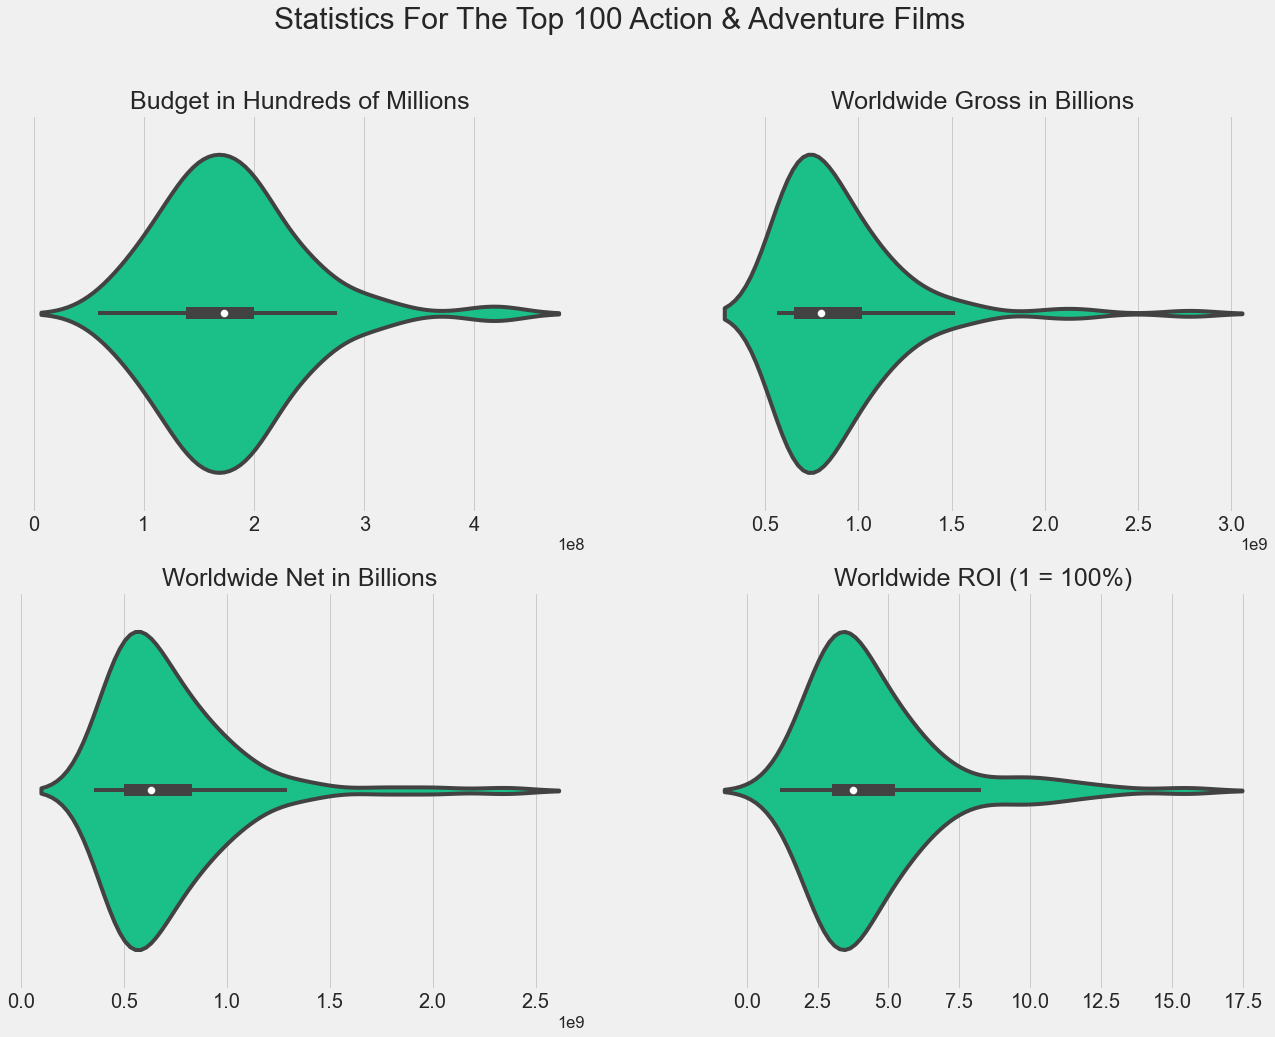

In [153]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=action)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=action)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=action)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=action)
fig.suptitle('Statistics For The Top 100 Action & Adventure Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [154]:
scifi_df = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles_s = scifi_df.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles_s.sort_values(by='worldwide_gross', ascending=False).head(100)
scifi = top100_scifi[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]

In [155]:
scifi.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2010.510000,1.658720e+08,8.159225e+08,6.500505e+08,4.756763
std,6.694631,6.833449e+07,3.287384e+08,2.985786e+08,3.456714
min,1990.000000,2.200000e+07,4.844686e+08,2.903591e+08,1.186484
25%,2007.000000,1.265000e+08,6.058507e+08,4.533670e+08,2.786869
50%,2013.000000,1.650000e+08,7.569612e+08,5.931777e+08,3.697996
75%,2016.000000,2.000000e+08,9.348282e+08,7.440441e+08,5.291970
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,22.527273


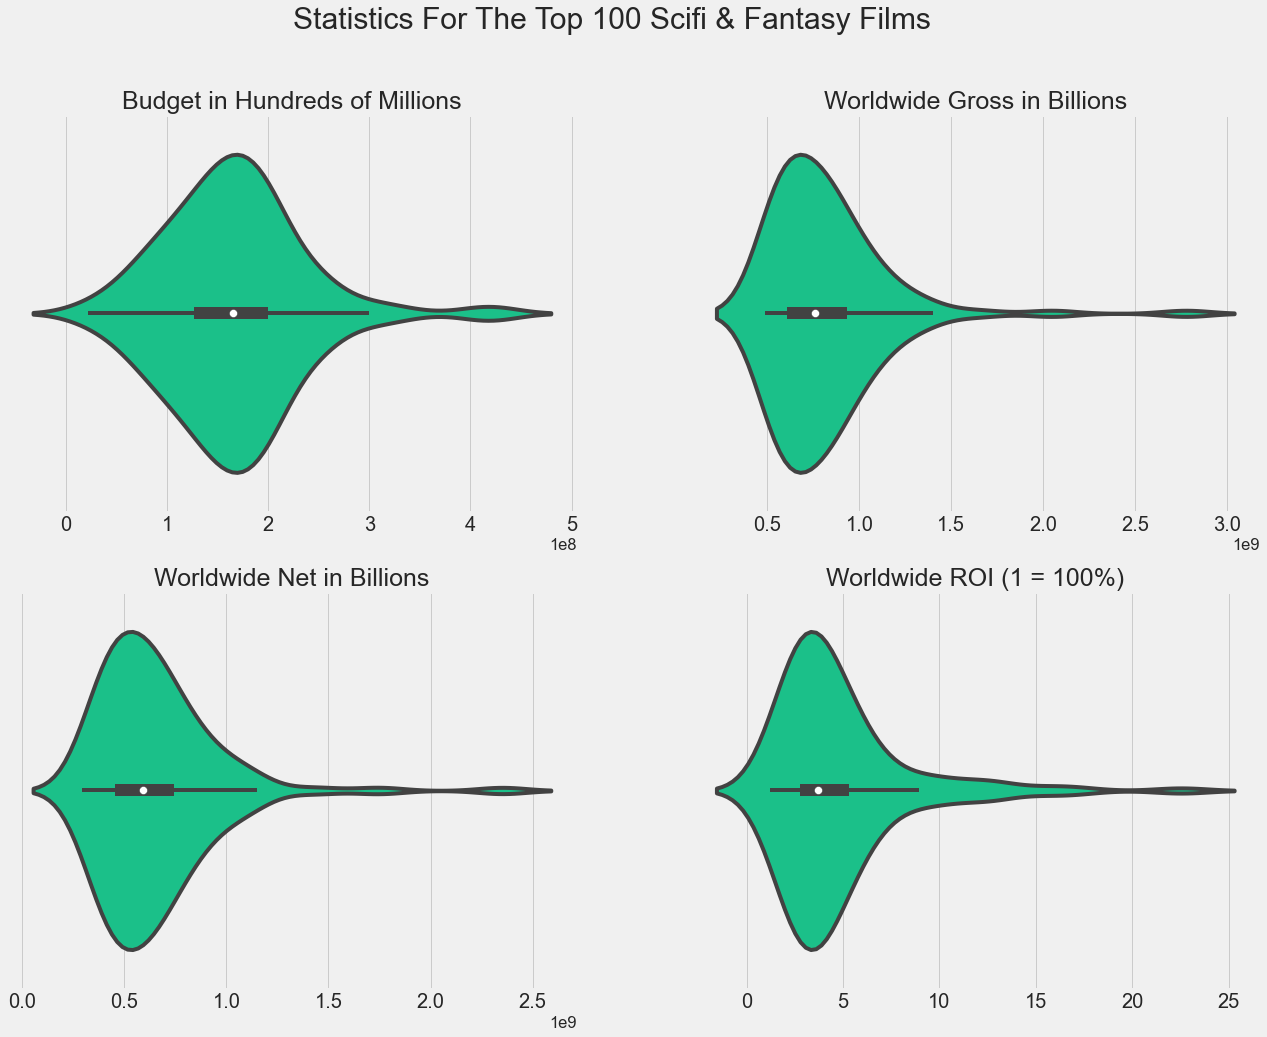

In [156]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=scifi)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=scifi)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=scifi)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=scifi)
fig.suptitle('Statistics For The Top 100 Scifi & Fantasy Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [157]:
drama_df = dfr[(dfr['genres'].str.contains('drama', case=False))]
unique_titles_d = drama_df.drop_duplicates(subset = ['title'])
top100_drama = unique_titles_d.sort_values(by='worldwide_gross', ascending=False).head(100)
drama = top100_drama[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]

In [158]:
drama.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.00000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.40000,1.251080e+08,6.150942e+08,4.899862e+08,6.236906
std,8.96683,6.618245e+07,2.977274e+08,2.808384e+08,6.548341
min,1975.00000,1.200000e+07,3.510404e+08,1.181513e+08,0.429641
25%,2003.75000,7.982500e+07,4.096143e+08,3.129614e+08,2.324162
50%,2011.00000,1.250000e+08,4.906174e+08,3.958058e+08,4.052838
75%,2016.00000,1.662500e+08,7.599021e+08,6.389709e+08,6.825000
max,2018.00000,3.000000e+08,2.208208e+09,2.008208e+09,38.225000


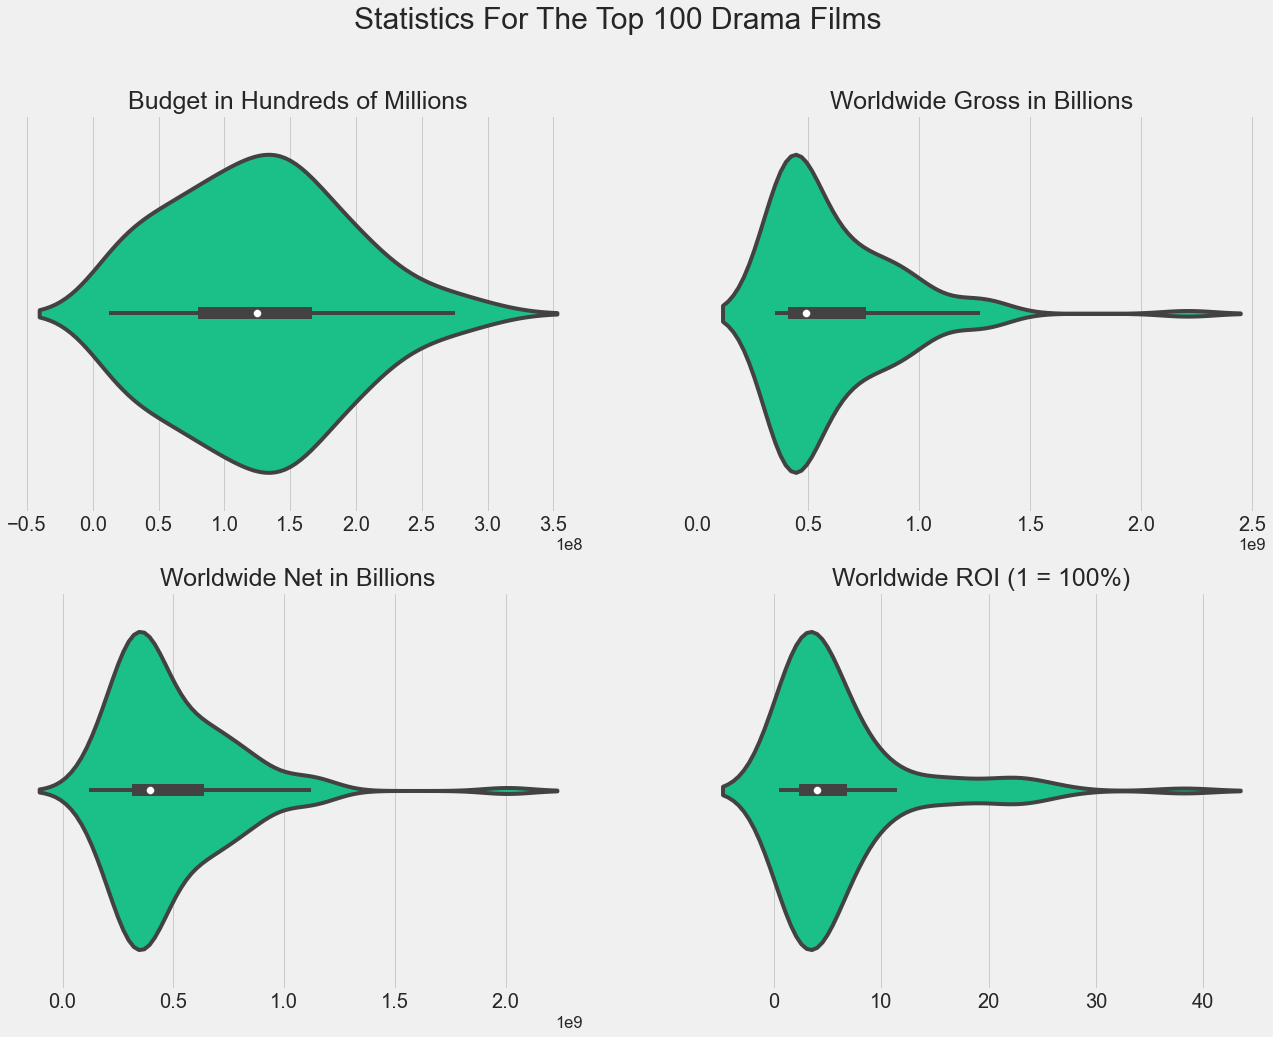

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=drama)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=drama)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=drama)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=drama)
fig.suptitle('Statistics For The Top 100 Drama Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [160]:
family_df = dfr[(dfr['genres'].str.contains('kids & family', case=False))]
unique_titles_f = family_df.drop_duplicates(subset = ['title'])
top100_family = unique_titles_f.sort_values(by='worldwide_gross', ascending=False).head(100)
family = top100_family[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]

In [161]:
family.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2008.470000,1.207530e+08,5.769052e+08,4.561522e+08,4.915782
std,7.280047,5.193093e+07,2.521281e+08,2.416251e+08,4.418321
min,1990.000000,1.500000e+07,2.988152e+08,1.413652e+08,0.780112
25%,2004.000000,7.922500e+07,3.629727e+08,2.676657e+08,2.344442
50%,2010.000000,1.262500e+08,5.111185e+08,4.069029e+08,3.493605
75%,2014.250000,1.512500e+08,7.444216e+08,5.651587e+08,5.593369
max,2019.000000,2.600000e+08,1.272470e+09,1.122470e+09,30.778978


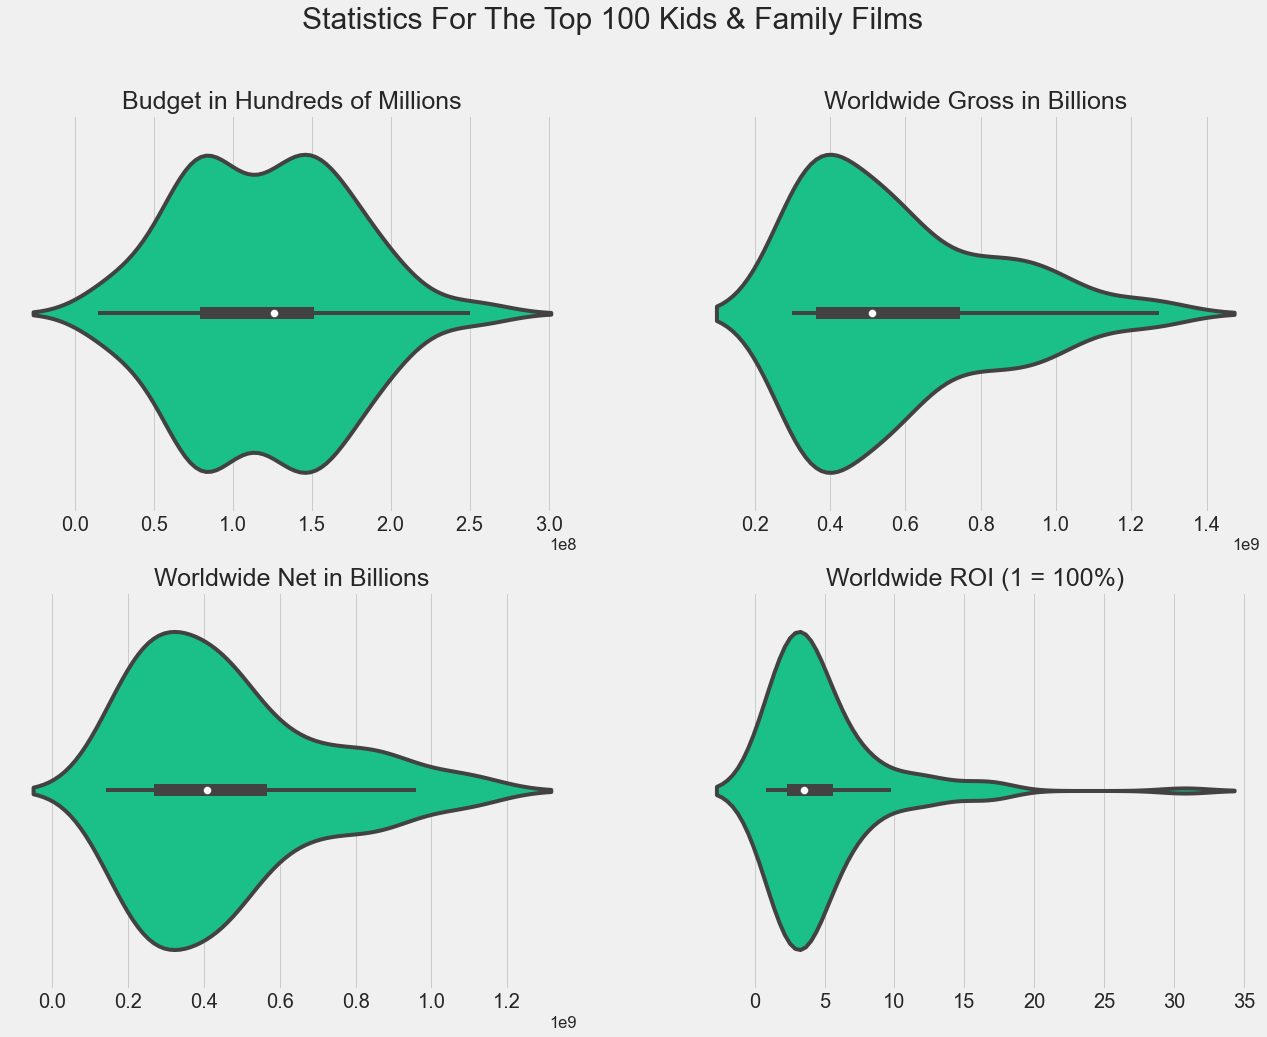

In [162]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=family)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=family)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=family)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=family)
fig.suptitle('Statistics For The Top 100 Kids & Family Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [163]:
mystery_df = dfr[(dfr['genres'].str.contains('mystery & suspense', case=False))]
unique_titles_m = mystery_df.drop_duplicates(subset = ['title'])
top100_mystery = unique_titles_m.sort_values(by='worldwide_gross', ascending=False).head(100)
mystery = top100_mystery[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net','worldwide_roi']]

In [164]:
mystery.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2005.120000,1.009113e+08,4.982518e+08,3.973405e+08,6.870262
std,9.177575,6.754731e+07,3.549953e+08,3.124608e+08,9.037675
min,1975.000000,5.000000e+06,2.398140e+08,8.924622e+07,0.509978
25%,1999.000000,5.937500e+07,3.015452e+08,2.304944e+08,2.423366
50%,2007.000000,9.000000e+07,3.656959e+08,2.996501e+08,3.444872
75%,2012.000000,1.300000e+08,5.550299e+08,4.300212e+08,7.004705
max,2019.000000,4.250000e+08,2.776345e+09,2.351345e+09,54.792961


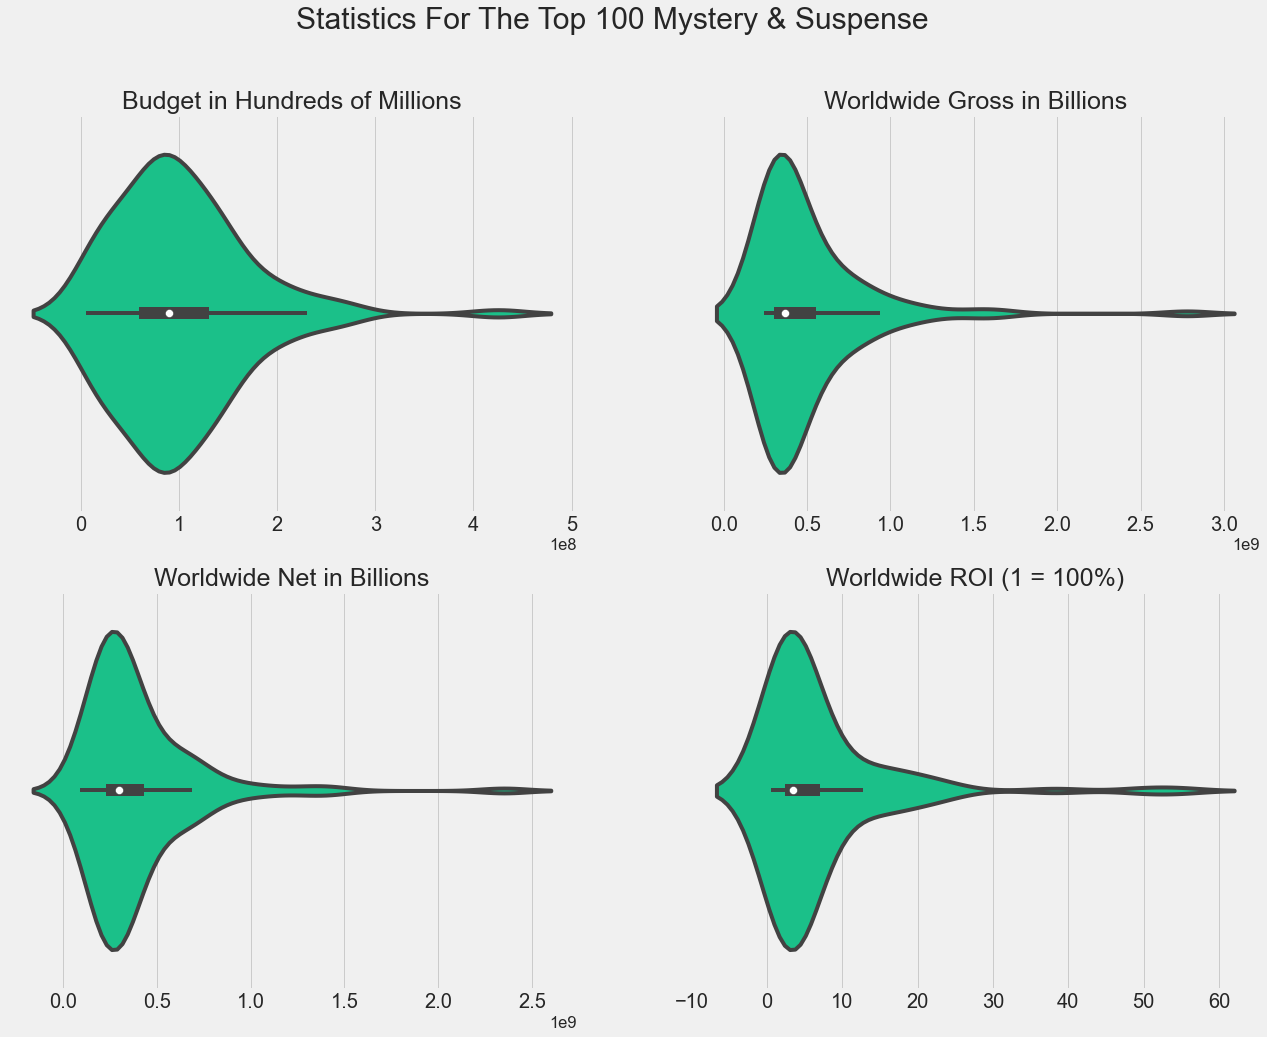

In [165]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=mystery)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=mystery)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=mystery)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=mystery)
fig.suptitle('Statistics For The Top 100 Mystery & Suspense', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

## Hidden Value Genres

In [166]:
comedy_df = dfr[(dfr['genres'].str.contains('comedy', case=False))]
unique_titles_c = comedy_df.drop_duplicates(subset = ['title'])
top100_comedy = unique_titles_c.sort_values(by='worldwide_gross', ascending=False).head(100)
comedy = top100_comedy[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]

In [167]:
comedy.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2006.780000,1.002610e+08,5.832438e+08,4.829828e+08,8.429684
std,8.392613,7.039659e+07,3.076128e+08,2.718090e+08,10.607837
min,1978.000000,5.000000e+06,3.320000e+08,1.462710e+08,0.780112
25%,2002.000000,5.500000e+07,3.846356e+08,3.263143e+08,3.228661
50%,2008.000000,8.500000e+07,5.170838e+08,4.231729e+08,5.158284
75%,2013.000000,1.312500e+08,6.285260e+08,5.279421e+08,9.251594
max,2018.000000,4.250000e+08,2.776345e+09,2.351345e+09,73.978007


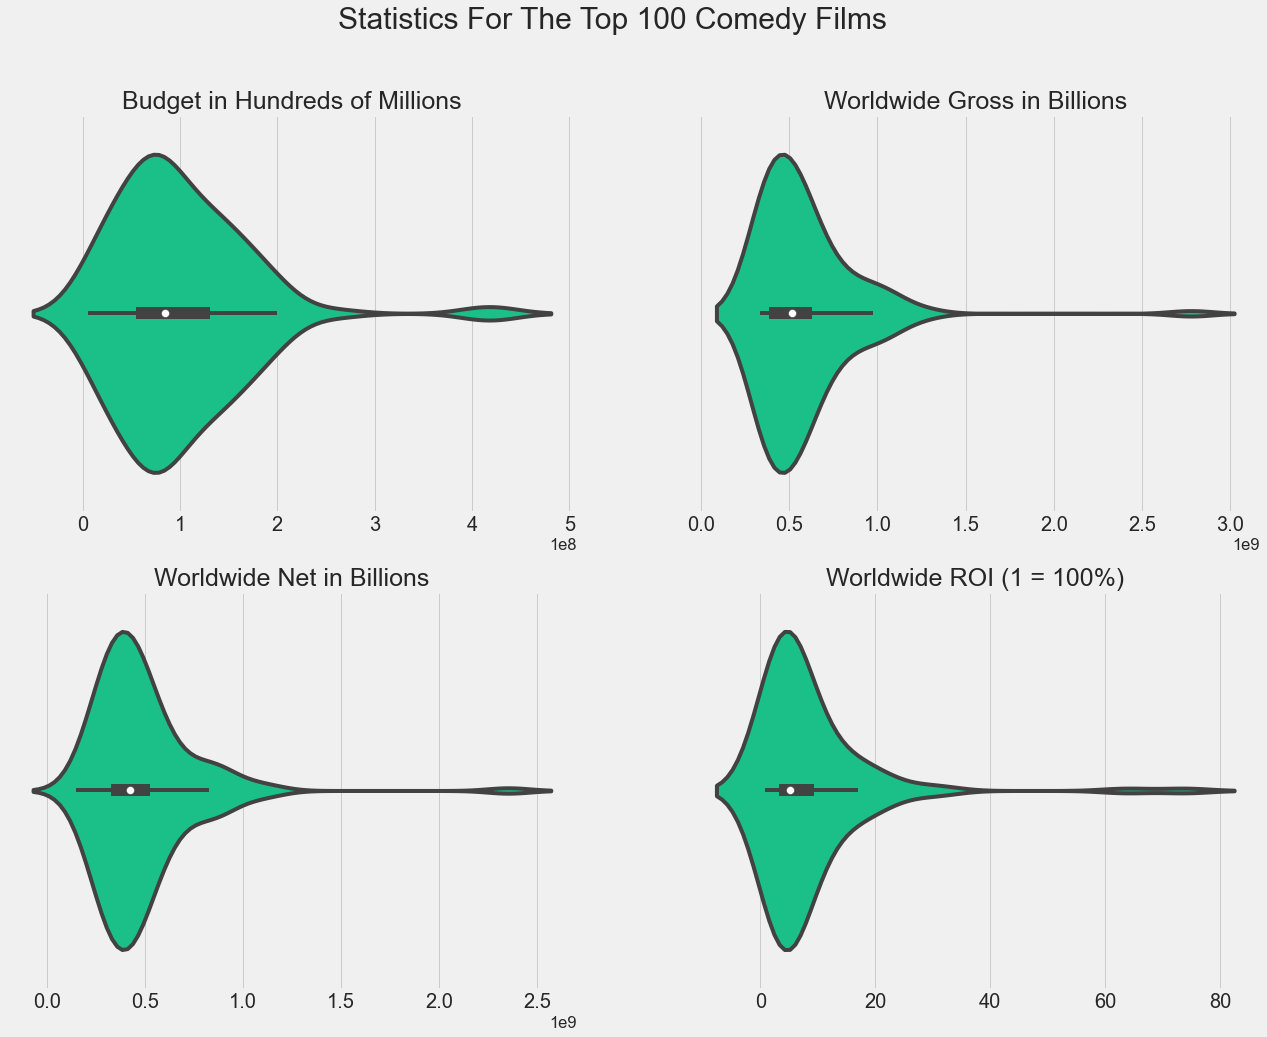

In [168]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=comedy)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=comedy)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=comedy)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=comedy)
fig.suptitle('Statistics For The Top 100 Comedy Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [169]:
horror_df = dfr[(dfr['genres'].str.contains('horror', case=False))]
unique_titles_h = horror_df.drop_duplicates(subset = ['title'])
top100_horror = unique_titles_h.sort_values(by='adj_ww_gross', ascending=False).head(100)
horror = top100_horror[['title', 'year', 'directors', 'authors',\
                        'actors', 'genres', 'production_budget', 'worldwide_gross',\
                        'worldwide_net', 'worldwide_roi']]

In [170]:
horror.describe()

,year,production_budget,worldwide_gross,worldwide_net,worldwide_roi
count,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000
mean,2003.830000,5.472600e+07,2.350136e+08,1.802876e+08,18.074178
std,11.077373,5.477207e+07,1.789311e+08,1.598030e+08,59.969619
min,1968.000000,4.500000e+05,3.339543e+07,-1.278725e+07,-0.106560
25%,1999.000000,1.500000e+07,1.360322e+08,9.060174e+07,1.797039
50%,2005.000000,4.000000e+07,1.727050e+08,1.316231e+08,3.898502
75%,2012.000000,7.575000e+07,2.760950e+08,2.276776e+08,12.498505
max,2019.000000,2.750000e+08,1.272470e+09,1.122470e+09,430.517853


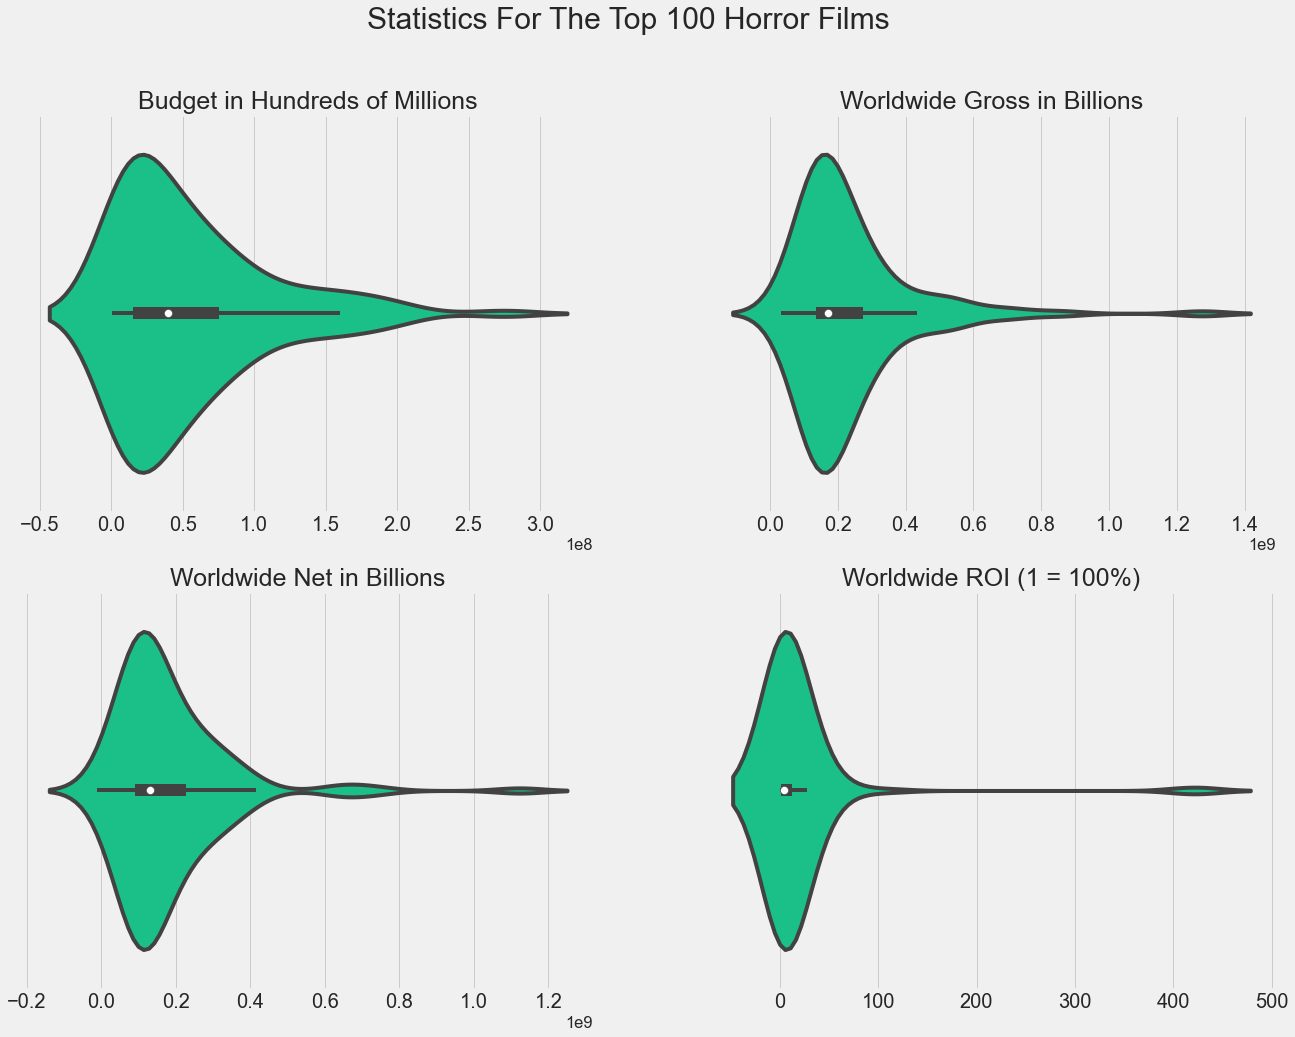

In [171]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
sns.violinplot(ax=axes[0, 0], x='production_budget', data=horror)
sns.violinplot(ax=axes[0, 1], x='worldwide_gross', data=horror)
sns.violinplot(ax=axes[1, 0], x='worldwide_net', data=horror)
sns.violinplot(ax=axes[1, 1], x='worldwide_roi', data=horror)
fig.suptitle('Statistics For The Top 100 Horror Films', size=30)
axes[0, 0].set_title('Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0, 0].tick_params(axis="x", labelsize=20)
axes[0, 1].tick_params(axis="x", labelsize=20)
axes[1, 0].tick_params(axis="x", labelsize=20)
axes[1, 1].tick_params(axis="x", labelsize=20)
plt.show()

In [172]:
title_net = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_titles = title_net.drop_duplicates(subset = ['title'])
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)

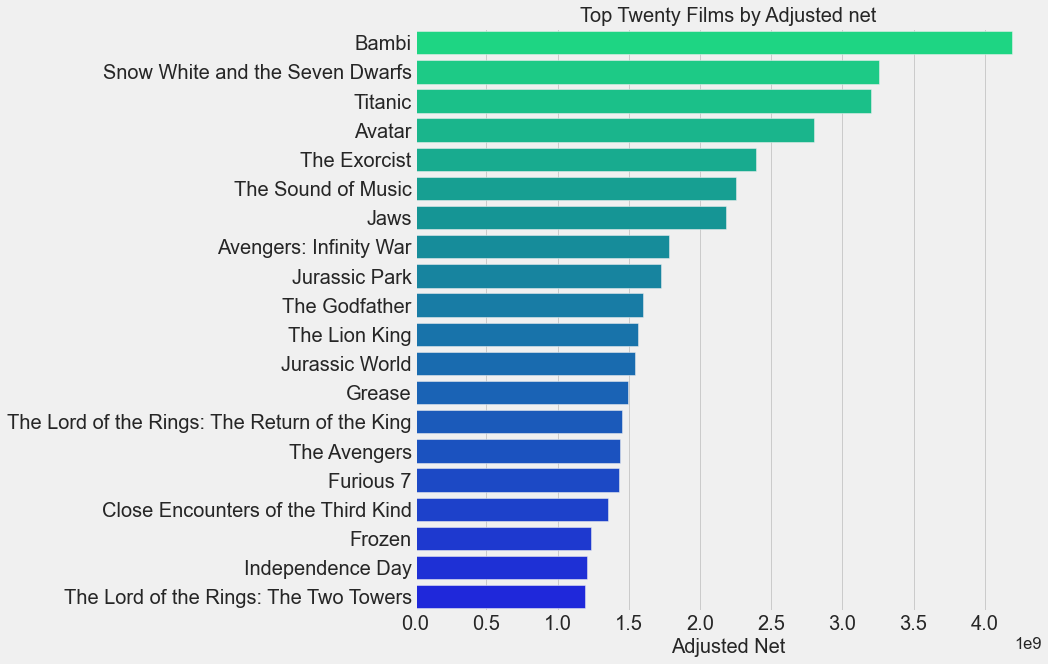

In [173]:
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_net', y='title', data= top20_net_films, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Adjusted Net", fontsize=20)
ax.set_ylabel("")
ax.set_title('Top Twenty Films by Adjusted net', size = 20)
plt.show()

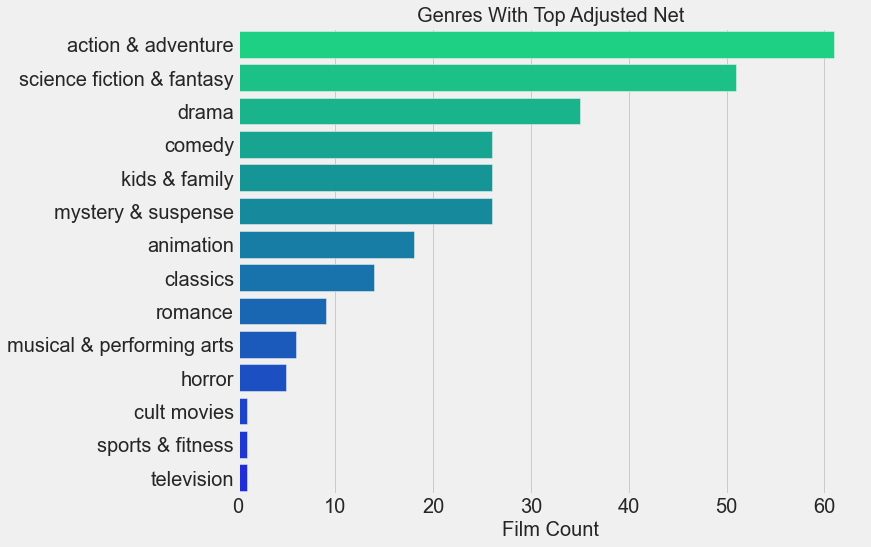

In [174]:
# top adjusted net genres; there are overlaps because a film can have multiple genres
net_genres = genre_count(top100_net_films, genres)
top_n_genres = pd.DataFrame()
top_n_genres['Genre'] = net_genres[0]
top_n_genres['Count'] = net_genres[1]
top_n_genres = top_n_genres.sort_values(by='Count', ascending=False).head(14)

fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x='Count', y='Genre', data=top_n_genres, palette='winter_r')
ax.tick_params(labelsize=20)
ax.set_xlabel("Film Count", fontsize=20 )
ax.set_ylabel("")
ax.set_title("Genres With Top Adjusted Net", fontsize=20)
plt.show()